In [1]:
import numpy as np
import awkward as ak
import tensorflow as tf
import matplotlib.pyplot as plt

from hepinfo.models.MiVAE import MiVAE
from hepinfo.util import readFromAnomalyBackgroundh5, readFromAnomalySignalh5, awkward_to_numpy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from sklearn.metrics import roc_auc_score

from functools import partial

from scipy.stats import ks_2samp

from qkeras import quantized_bits
from qkeras.utils import _add_supported_quantized_objects
co = {}; _add_supported_quantized_objects(co)

import h5py
import mplhep
mplhep.style.use('CMS')

In [2]:
# plot scripts

def do_ks_test(a, b, name):
    ks_stat, p_value = ks_2samp(a, b)

    if p_value < 0.05:
        print(f"The distributions for {name} are significantly different value={round(ks_stat, 3)}.")
    else:
        print(f"No significant difference between the distributions for {name} with value={round(ks_stat, 3)}.")

def plot_history(history):
    plt.plot(history.history['loss'], label='Train Total Loss')
    plt.plot(history.history['reconstruction_loss'], label='Train Reconstruction Loss')
    plt.plot(history.history['kl_loss'], label='Train KL Loss')
    plt.plot(history.history['mi_loss'], label='Train MI Loss')
    plt.yscale("log")
    plt.ylabel("Total loss")
    plt.xlabel("Epoch")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def plot_score(normal_score, abnormal_score, bin_size=100, xlabel="Reconstruction Loss", ylabel="Probability (a.u.)", label_normal="dijet+ttbar", label_abnormal="higgs"):
    # get range for peak
    combined = np.concatenate([normal_score, abnormal_score])
    lower_bound = np.percentile(combined, 1)
    upper_bound = np.percentile(combined, 99)

    plt.hist(normal_score, bins=bin_size, label=label_normal, density=True, histtype='step', fill=False, linewidth=1.5, range=(lower_bound, upper_bound))
    plt.hist(abnormal_score, bins=bin_size, label=label_abnormal, density=True, histtype='step', fill=False, linewidth=1.5, range=(lower_bound, upper_bound))
    plt.yscale('log')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.show()

def plot_roc(y_test, y_pred, name="Reconstruction", plot=True):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_value = auc(fpr, tpr)

    # find the index of the maximum Youden's J
    youden_j = tpr - fpr
    best_index = np.argmax(youden_j)
    best_threshold = thresholds[best_index]

    if plot:
        plt.scatter(fpr[best_index], tpr[best_index])
        plt.plot(fpr, tpr, "-", label=f"{name} (auc = {round(auc_value, 3)})", linewidth=1.5)
        return best_threshold
    else:
        return best_threshold, auc_value

def get_plots(model, normal_data, abnormal_data, nPV_normal, nPV_abnormal, name=r"$\gamma=0$", use_axio=False, label_normal="dijet+ttbar", label_abnormal="higgs"):

    if use_axio:
        normal_score = model.predict(normal_data)
        normal_score = np.sum(normal_score**2, axis=1)
        abnormal_score = model.predict(abnormal_data)
        abnormal_score = np.sum(abnormal_score**2, axis=1)

        plot_score(normal_score, abnormal_score, xlabel=r"$\sum \mu^2$ score axol1tl", ylabel="Probability (a.u.)", label_normal=label_normal, label_abnormal=label_abnormal)

        # generate plots for the ROC curves
        y_test = np.concatenate((np.ones(len(abnormal_score)), np.zeros(len(normal_score))))
        thr = plot_roc(y_test, np.concatenate((abnormal_score, normal_score)), name=r"$\sum \mu^2$ score axol1tl")

        plt.ylabel("True Positive Rate")
        plt.xlabel("False Positive Rate")
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
        plt.show()

        # generate plots for pile-up studies
        bins = 20

        if not nPV_normal is None: plt.hist(nPV_normal, bins=bins, density=True, alpha=0.3, label=f"{label_normal} no cut " + name)
        if not nPV_abnormal is None: plt.hist(nPV_abnormal, bins=bins, density=True, alpha=0.3, label=f"{label_abnormal} no cut " + name)

        if not nPV_normal is None: plt.hist(nPV_normal[normal_score > thr], bins=bins, density=True, alpha=0.3, label=label_normal + r" $\sum \mu^2$ score cut")
        if not nPV_abnormal is None: plt.hist(nPV_abnormal[abnormal_score > thr], bins=bins, density=True, alpha=0.3, label=label_abnormal + r" $\sum \mu^2$ score cut")

        if nPV_normal is not None or nPV_abnormal is not None:
            plt.xlabel("nPV")
            plt.ylabel("Events (%)")

            plt.legend(loc='best', ncol=2, prop={'size': 8})
            plt.grid(True)

            plt.show()

        if not nPV_normal is None: do_ks_test(nPV_normal, nPV_normal[normal_score > thr], label_normal + " $\sum \mu^2$ score")
        if not nPV_abnormal is None: do_ks_test(nPV_abnormal, nPV_abnormal[abnormal_score > thr], label_abnormal + " $\sum \mu^2$ score")
    else:
        recon_normal_score = np.nan_to_num(model.score_vector(normal_data)[0])
        recon_abnormal_score = np.nan_to_num(model.score_vector(abnormal_data)[0])

        kl_normal_score = np.nan_to_num(model.score_vector(normal_data)[1])
        kl_abnormal_score = np.nan_to_num(model.score_vector(abnormal_data)[1])

        total_normal_score = np.nan_to_num(model.score_vector(normal_data)[2])
        total_abnormal_score = np.nan_to_num(model.score_vector(abnormal_data)[2])
        
        mean_normal_score = model.get_mean(normal_data).numpy()
        mean_normal_score = np.sum(mean_normal_score**2, axis=1)
        mean_abnormal_score = model.get_mean(abnormal_data).numpy()
        mean_abnormal_score = np.sum(mean_abnormal_score**2, axis=1)

        sigma_normal_score = model.get_sigma(normal_data).numpy()
        sigma_normal_score = np.sum(sigma_normal_score**2, axis=1)
        sigma_abnormal_score = model.get_sigma(abnormal_data).numpy()
        sigma_abnormal_score = np.sum(sigma_abnormal_score**2, axis=1)

        plot_score(recon_normal_score, recon_abnormal_score, xlabel="Reconstruction score " + name, ylabel="Probability (a.u.)", label_normal=label_normal, label_abnormal=label_abnormal)
        plot_score(kl_normal_score, kl_abnormal_score, xlabel="KL score " + name, ylabel="Probability (a.u.)", label_normal=label_normal, label_abnormal=label_abnormal)
        plot_score(total_normal_score, total_abnormal_score, xlabel="Total score " + name, ylabel="Probability (a.u.)", label_normal=label_normal, label_abnormal=label_abnormal)
        plot_score(mean_normal_score, mean_abnormal_score, xlabel=r"$\sum \mu^2$ score " + name, ylabel="Probability (a.u.)", label_normal=label_normal, label_abnormal=label_abnormal)
        plot_score(sigma_normal_score, sigma_abnormal_score, xlabel=r"$\sum \sigma^2$ score " + name, ylabel="Probability (a.u.)", label_normal=label_normal, label_abnormal=label_abnormal)

        # generate plots for the ROC curves
        y_test = np.concatenate((np.ones(len(recon_abnormal_score)), np.zeros(len(recon_normal_score))))
        thr_recon = plot_roc(y_test, np.concatenate((recon_abnormal_score, recon_normal_score)), name="Reconstruction score " + name)
        thr_kl = plot_roc(y_test, np.concatenate((kl_abnormal_score, kl_normal_score)), name="KL score " + name)
        thr_total = plot_roc(y_test, np.concatenate((total_abnormal_score, total_normal_score)), name="Total score " + name)
        thr_mean = plot_roc(y_test, np.concatenate((mean_abnormal_score, mean_normal_score)), name=r"$\sum \mu^2$ score " + name)
        thr_sigma = plot_roc(y_test, np.concatenate((sigma_abnormal_score, sigma_normal_score)), name=r"$\sum \sigma^2$ score " + name)

        plt.ylabel("True Positive Rate")
        plt.xlabel("False Positive Rate")
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
        plt.show()

        # generate plots for pile-up studies
        bins = 20

        if not nPV_normal is None: plt.hist(nPV_normal, bins=bins, density=True, alpha=0.3, label=f"{label_normal} no cut " + name)
        if not nPV_abnormal is None: plt.hist(nPV_abnormal, bins=bins, density=True, alpha=0.3, label=f"{label_abnormal} no cut " + name)
        if not nPV_normal is None: plt.hist(nPV_normal[recon_normal_score > thr_recon], bins=bins, density=True, alpha=0.3, label=f"{label_normal} recon cut")
        if not nPV_abnormal is None: plt.hist(nPV_abnormal[recon_abnormal_score > thr_recon], bins=bins, density=True, alpha=0.3, label=f"{label_abnormal} recon cut")

        if nPV_normal is not None or nPV_abnormal is not None:
            plt.xlabel("nPV")
            plt.ylabel("Events (%)")

            plt.legend(loc='best', ncol=2, prop={'size': 8})
            plt.grid(True)

            plt.show()

        if not nPV_normal is None: plt.hist(nPV_normal, bins=bins, density=True, alpha=0.3, label=f"{label_normal} no cut " + name)
        if not nPV_abnormal is None: plt.hist(nPV_abnormal, bins=bins, density=True, alpha=0.3, label=f"{label_abnormal} no cut " + name)
        if not nPV_normal is None: plt.hist(nPV_normal[kl_normal_score > thr_kl], bins=bins, density=True, alpha=0.3, label=f"{label_normal} KL cut")
        if not nPV_abnormal is None: plt.hist(nPV_abnormal[kl_abnormal_score > thr_kl], bins=bins, density=True, alpha=0.3, label=f"{label_abnormal} KL cut")

        if nPV_normal is not None or nPV_abnormal is not None:
            plt.xlabel("nPV")
            plt.ylabel("Events (%)")

            plt.legend(loc='best', ncol=2, prop={'size': 8})
            plt.grid(True)

            plt.show()

        if not nPV_normal is None: plt.hist(nPV_normal, bins=bins, density=True, alpha=0.3, label=f"{label_normal} no cut " + name)
        if not nPV_abnormal is None: plt.hist(nPV_abnormal, bins=bins, density=True, alpha=0.3, label=f"{label_abnormal} no cut " + name)
        if not nPV_normal is None: plt.hist(nPV_normal[total_normal_score > thr_total], bins=bins, density=True, alpha=0.3, label=f"{label_normal} total cut")
        if not nPV_abnormal is None: plt.hist(nPV_abnormal[total_abnormal_score > thr_total], bins=bins, density=True, alpha=0.3, label=f"{label_abnormal} total cut")

        if nPV_normal is not None or nPV_abnormal is not None:
            plt.xlabel("nPV")
            plt.ylabel("Events (%)")

            plt.legend(loc='best', ncol=2, prop={'size': 8})
            plt.grid(True)

            plt.show()

        if not nPV_normal is None: plt.hist(nPV_normal, bins=bins, density=True, alpha=0.3, label=f"{label_normal} no cut " + name)
        if not nPV_abnormal is None: plt.hist(nPV_abnormal, bins=bins, density=True, alpha=0.3, label=f"{label_abnormal} no cut " + name)
        if not nPV_normal is None: plt.hist(nPV_normal[mean_normal_score > thr_mean], bins=bins, density=True, alpha=0.3, label=label_normal + r" $\sum \mu^2$ score cut " + name)
        if not nPV_abnormal is None: plt.hist(nPV_abnormal[mean_abnormal_score > thr_mean], bins=bins, density=True, alpha=0.3, label=label_abnormal + r" $\sum \mu^2$ score cut " + name)

        if nPV_normal is not None or nPV_abnormal is not None:
            plt.xlabel("nPV")
            plt.ylabel("Events (%)")

            plt.legend(loc='best', ncol=2, prop={'size': 8})
            plt.grid(True)

            plt.show()

        if not nPV_normal is None: plt.hist(nPV_normal, bins=bins, density=True, alpha=0.3, label=f"{label_normal} no cut " + name)
        if not nPV_abnormal is None: plt.hist(nPV_abnormal, bins=bins, density=True, alpha=0.3, label=f"{label_abnormal} no cut " + name)
        if not nPV_normal is None: plt.hist(nPV_normal[sigma_normal_score > thr_sigma], bins=bins, density=True, alpha=0.3, label=label_normal + r" $\sum \mu^2$ score cut " + name)
        if not nPV_abnormal is None: plt.hist(nPV_abnormal[sigma_abnormal_score > thr_sigma], bins=bins, density=True, alpha=0.3, label=label_abnormal + r" $\sum \mu^2$ score cut " + name)

        if nPV_normal is not None or nPV_abnormal is not None:
            plt.xlabel("nPV")
            plt.ylabel("Events (%)")

            plt.legend(loc='best', ncol=2, prop={'size': 8})
            plt.grid(True)

            plt.show()

        if not nPV_normal is None and len(nPV_normal[recon_normal_score > thr_recon]) > 0: do_ks_test(nPV_normal, nPV_normal[recon_normal_score > thr_recon], label_normal + " recon cut")
        if not nPV_abnormal is None and len(nPV_abnormal[recon_abnormal_score > thr_recon]) > 0: do_ks_test(nPV_abnormal, nPV_abnormal[recon_abnormal_score > thr_recon], label_abnormal + " recon cut")

        if not nPV_normal is None and len(nPV_normal[kl_normal_score > thr_kl]) > 0: do_ks_test(nPV_normal, nPV_normal[kl_normal_score > thr_kl], label_normal + " KL cut")
        if not nPV_abnormal is None and len(nPV_abnormal[kl_abnormal_score > thr_kl]) > 0: do_ks_test(nPV_abnormal, nPV_abnormal[kl_abnormal_score > thr_kl], label_abnormal + " KL cut")

        if not nPV_normal is None and len(nPV_normal[total_normal_score > thr_total]) > 0: do_ks_test(nPV_normal, nPV_normal[total_normal_score > thr_total], label_normal + " total cut")
        if not nPV_abnormal is None and len(nPV_abnormal[total_abnormal_score > thr_total]) > 0: do_ks_test(nPV_abnormal, nPV_abnormal[total_abnormal_score > thr_total], label_abnormal + " total cut")

        if not nPV_normal is None and len(nPV_normal[mean_normal_score > thr_mean]) > 0: do_ks_test(nPV_normal, nPV_normal[mean_normal_score > thr_mean], label_normal + r" $\sum \mu^2$ score cut " + name)
        if not nPV_abnormal is None and len(nPV_abnormal[mean_abnormal_score > thr_mean]) > 0: do_ks_test(nPV_abnormal, nPV_abnormal[mean_abnormal_score > thr_mean], label_abnormal + r" $\sum \mu^2$ score cut " + name)

        if not nPV_normal is None and len(nPV_normal[sigma_normal_score > thr_sigma]) > 0: do_ks_test(nPV_normal, nPV_normal[sigma_normal_score > thr_sigma], label_normal + r" $\sum \sigma^2$ score cut " + name)
        if not nPV_abnormal is None and len(nPV_abnormal[sigma_abnormal_score > thr_sigma]) > 0: do_ks_test(nPV_abnormal, nPV_abnormal[sigma_abnormal_score > thr_sigma], label_abnormal + r" $\sum \sigma^2$ score cut " + name)



In [3]:
# read in the data
normal_data = np.load("../data/normal_data.npy", allow_pickle=True)
abnormal_data = np.load("../data/abnormal_data.npy", allow_pickle=True)

In [4]:
# perform some pre-processing and split into train test
nPV = normal_data[:,0]
nPV_abnormal = abnormal_data[:,0]
X = normal_data[:,1:]
abnormal_data = abnormal_data[:,1:]

X_train, X_test, nPV_train, nPV_test = train_test_split(X, nPV, shuffle=True)
abnormal_data_train, abnormal_data_test, nPV_abnormal_train, nPV_abnormal_test = train_test_split(abnormal_data, nPV_abnormal, shuffle=True)

scaler = MinMaxScaler() # add robast scaler
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
abnormal_data_train_scaled = scaler.transform(abnormal_data_train)
abnormal_data_test_scaled = scaler.transform(abnormal_data_test)

Fit gamma  0.0


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_activation_9     │ (None, 57)        │          1 │ input_layer_20[0… │
│ (TQActivation)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_18         │ (None, 32)        │      1,859 │ tq_activation_9[… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ tq_dense_18[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_19         │ (None, 16)        │        531 │ batch_normalizat… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ tq_dense_19[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (TQDense)    │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (TQDense) │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_10         │ (None, 8)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bernoulli           │ (None, 8)         │          0 │ sampling_10[0][0] │
│ (BernoulliSampling) │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,861 (11.18 KB)

 Trainable params: 2,765 (10.80 KB)

 Non-trainable params: 96 (384.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,761 (10.79 KB)

 Trainable params: 2,665 (10.41 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/10


W0000 00:00:1736791688.972947 94878566 loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/map/while/body/_141/map/while/cond/branch_executed/_777


586/586 - 7s - 11ms/step - bops: 84492.0938 - kl_loss: 4.4398 - loss: 84496.5703 - mi_loss: 0.0000e+00 - reconstruction_loss: 0.0205
Epoch 2/10
586/586 - 3s - 5ms/step - bops: 83484.5703 - kl_loss: 0.7004 - loss: 83485.3281 - mi_loss: 0.0000e+00 - reconstruction_loss: 0.0116
Epoch 3/10
586/586 - 3s - 5ms/step - bops: 82757.3203 - kl_loss: 0.3487 - loss: 82757.7188 - mi_loss: 0.0000e+00 - reconstruction_loss: 0.0115
Epoch 4/10
586/586 - 3s - 5ms/step - bops: 82187.4219 - kl_loss: 0.2199 - loss: 82187.6484 - mi_loss: 0.0000e+00 - reconstruction_loss: 0.0115
Epoch 5/10
586/586 - 3s - 6ms/step - bops: 81718.5469 - kl_loss: 0.1547 - loss: 81718.7031 - mi_loss: 0.0000e+00 - reconstruction_loss: 0.0115
Epoch 6/10
586/586 - 3s - 5ms/step - bops: 81320.1641 - kl_loss: 0.1163 - loss: 81320.2969 - mi_loss: 0.0000e+00 - reconstruction_loss: 0.0115
Epoch 7/10
586/586 - 3s - 5ms/step - bops: 80973.8125 - kl_loss: 0.0907 - loss: 80973.9219 - mi_loss: 0.0000e+00 - reconstruction_loss: 0.0115
Epoch 8/1

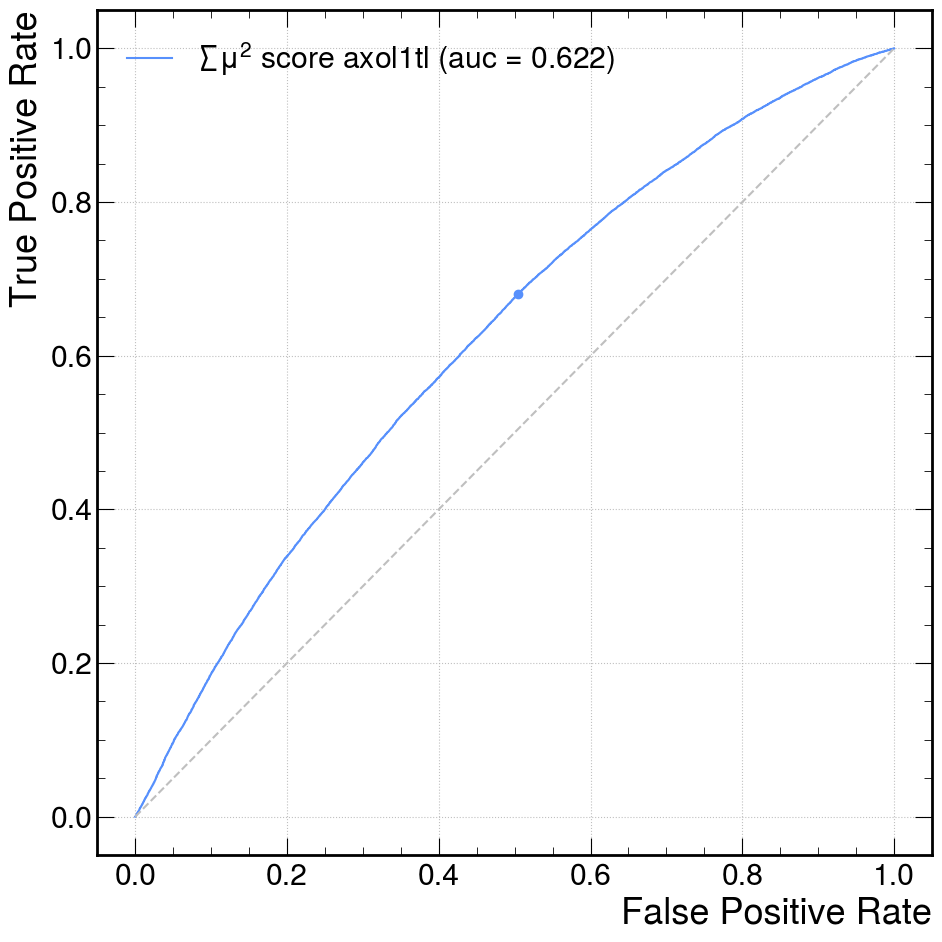

Fit gamma  0.1111111111111111


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_activation_10    │ (None, 57)        │          1 │ input_layer_22[0… │
│ (TQActivation)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_20         │ (None, 32)        │      1,859 │ tq_activation_10… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ tq_dense_20[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_21         │ (None, 16)        │        531 │ batch_normalizat… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ tq_dense_21[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (TQDense)    │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (TQDense) │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_11         │ (None, 8)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bernoulli           │ (None, 8)         │          0 │ sampling_11[0][0] │
│ (BernoulliSampling) │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,861 (11.18 KB)

 Trainable params: 2,765 (10.80 KB)

 Non-trainable params: 96 (384.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,761 (10.79 KB)

 Trainable params: 2,665 (10.41 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/10


W0000 00:00:1736791722.281417 94878566 loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/map/while/body/_141/map/while/cond/branch_executed/_777


586/586 - 6s - 10ms/step - bops: 84492.0938 - kl_loss: 2.5128 - loss: 84494.6719 - mi_loss: 0.0438 - reconstruction_loss: 0.0191
Epoch 2/10
586/586 - 3s - 5ms/step - bops: 83484.5703 - kl_loss: 0.1546 - loss: 83484.7344 - mi_loss: 0.0104 - reconstruction_loss: 0.0116
Epoch 3/10
586/586 - 3s - 5ms/step - bops: 82757.3203 - kl_loss: 0.0523 - loss: 82757.4062 - mi_loss: 0.0045 - reconstruction_loss: 0.0115
Epoch 4/10
586/586 - 3s - 5ms/step - bops: 82187.4219 - kl_loss: 0.0273 - loss: 82187.4766 - mi_loss: 0.0025 - reconstruction_loss: 0.0115
Epoch 5/10
586/586 - 3s - 5ms/step - bops: 81718.5469 - kl_loss: 0.0169 - loss: 81718.5703 - mi_loss: 0.0016 - reconstruction_loss: 0.0115
Epoch 6/10
586/586 - 3s - 5ms/step - bops: 81320.1641 - kl_loss: 0.0115 - loss: 81320.1953 - mi_loss: 0.0011 - reconstruction_loss: 0.0115
Epoch 7/10
586/586 - 3s - 5ms/step - bops: 80973.8125 - kl_loss: 0.0082 - loss: 80973.8359 - mi_loss: 7.9106e-04 - reconstruction_loss: 0.0115
Epoch 8/10
586/586 - 3s - 5ms/ste

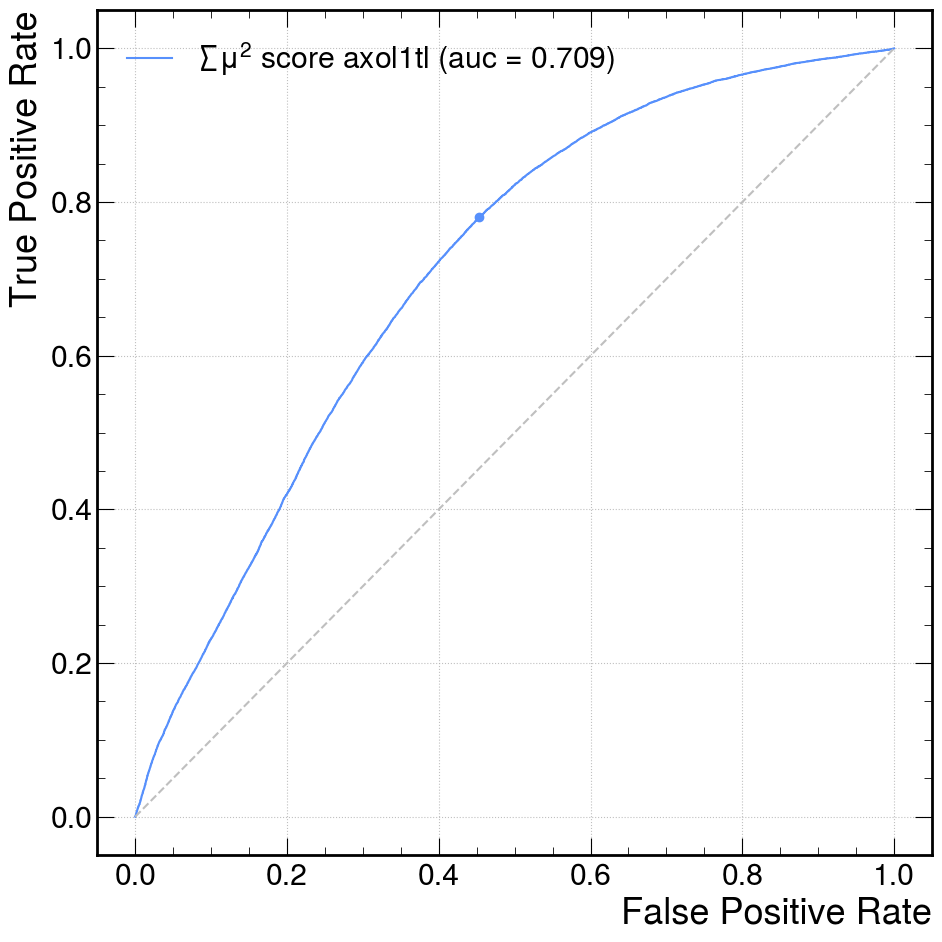

Fit gamma  0.2222222222222222


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_activation_11    │ (None, 57)        │          1 │ input_layer_24[0… │
│ (TQActivation)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_22         │ (None, 32)        │      1,859 │ tq_activation_11… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ tq_dense_22[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_23         │ (None, 16)        │        531 │ batch_normalizat… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ tq_dense_23[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (TQDense)    │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (TQDense) │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_12         │ (None, 8)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bernoulli           │ (None, 8)         │          0 │ sampling_12[0][0] │
│ (BernoulliSampling) │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,861 (11.18 KB)

 Trainable params: 2,765 (10.80 KB)

 Non-trainable params: 96 (384.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,761 (10.79 KB)

 Trainable params: 2,665 (10.41 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/10


W0000 00:00:1736791754.092305 94878566 loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/map/while/body/_141/map/while/cond/branch_executed/_777


586/586 - 6s - 11ms/step - bops: 84492.0938 - kl_loss: 7.7286 - loss: 84499.9375 - mi_loss: 0.1045 - reconstruction_loss: 0.0191
Epoch 2/10
586/586 - 3s - 5ms/step - bops: 83484.5703 - kl_loss: 1.1502 - loss: 83485.8125 - mi_loss: 0.0468 - reconstruction_loss: 0.0116
Epoch 3/10
586/586 - 3s - 5ms/step - bops: 82757.3203 - kl_loss: 0.5899 - loss: 82757.9609 - mi_loss: 0.0208 - reconstruction_loss: 0.0115
Epoch 4/10
586/586 - 3s - 5ms/step - bops: 82187.4219 - kl_loss: 0.3779 - loss: 82187.8125 - mi_loss: 0.0117 - reconstruction_loss: 0.0115
Epoch 5/10
586/586 - 3s - 5ms/step - bops: 81718.5469 - kl_loss: 0.2677 - loss: 81718.8203 - mi_loss: 0.0067 - reconstruction_loss: 0.0115
Epoch 6/10
586/586 - 3s - 5ms/step - bops: 81320.1641 - kl_loss: 0.2040 - loss: 81320.3984 - mi_loss: 0.0042 - reconstruction_loss: 0.0115
Epoch 7/10
586/586 - 3s - 5ms/step - bops: 80973.8125 - kl_loss: 0.1611 - loss: 80973.9922 - mi_loss: 0.0025 - reconstruction_loss: 0.0115
Epoch 8/10
586/586 - 3s - 5ms/step - 

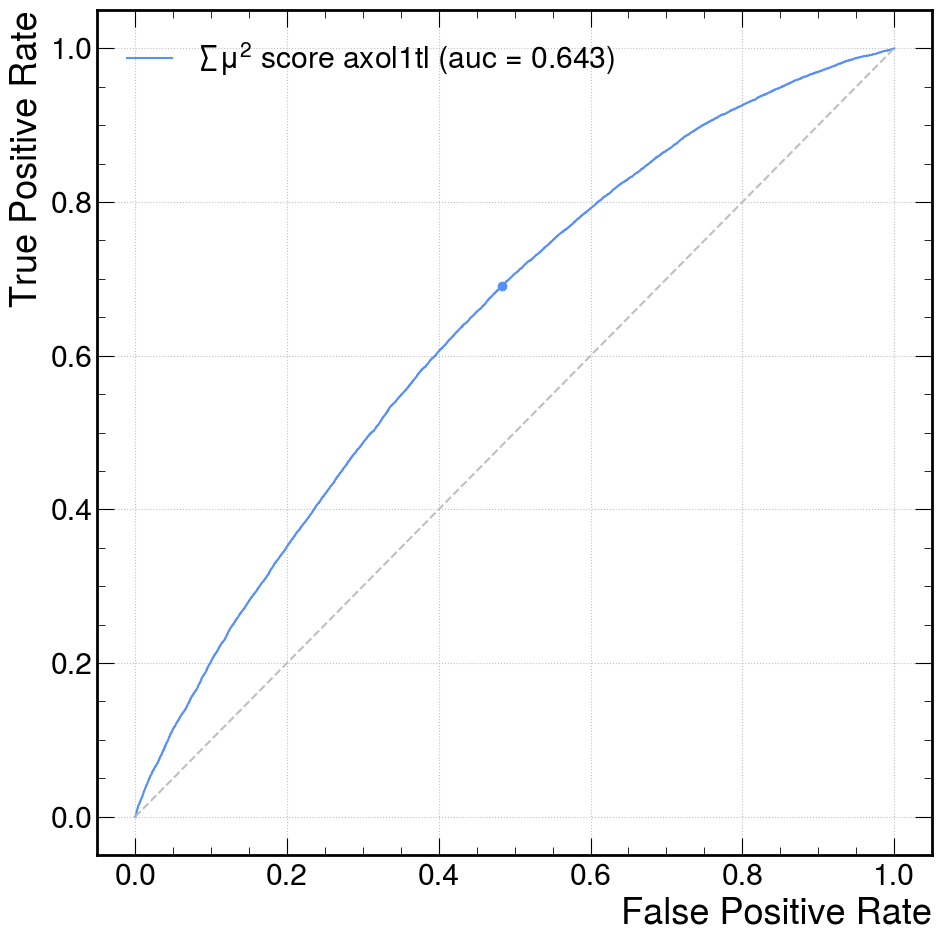

Fit gamma  0.3333333333333333


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_activation_12    │ (None, 57)        │          1 │ input_layer_26[0… │
│ (TQActivation)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_24         │ (None, 32)        │      1,859 │ tq_activation_12… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ tq_dense_24[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_25         │ (None, 16)        │        531 │ batch_normalizat… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ tq_dense_25[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (TQDense)    │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (TQDense) │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_13         │ (None, 8)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bernoulli           │ (None, 8)         │          0 │ sampling_13[0][0] │
│ (BernoulliSampling) │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,861 (11.18 KB)

 Trainable params: 2,765 (10.80 KB)

 Non-trainable params: 96 (384.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,761 (10.79 KB)

 Trainable params: 2,665 (10.41 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/10


W0000 00:00:1736791785.274640 94878566 loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/cond/branch_executed/_139


586/586 - 6s - 11ms/step - bops: 84492.0938 - kl_loss: 1.8732 - loss: 84494.1328 - mi_loss: 0.1073 - reconstruction_loss: 0.0201
Epoch 2/10
586/586 - 3s - 5ms/step - bops: 83484.5703 - kl_loss: 0.0847 - loss: 83484.6719 - mi_loss: 0.0180 - reconstruction_loss: 0.0116
Epoch 3/10
586/586 - 3s - 5ms/step - bops: 82757.3203 - kl_loss: 0.0282 - loss: 82757.3750 - mi_loss: 0.0074 - reconstruction_loss: 0.0115
Epoch 4/10
586/586 - 3s - 5ms/step - bops: 82187.4219 - kl_loss: 0.0126 - loss: 82187.4688 - mi_loss: 0.0034 - reconstruction_loss: 0.0115
Epoch 5/10
586/586 - 3s - 5ms/step - bops: 81718.5469 - kl_loss: 0.0074 - loss: 81718.5703 - mi_loss: 0.0020 - reconstruction_loss: 0.0115
Epoch 6/10
586/586 - 3s - 6ms/step - bops: 81320.1641 - kl_loss: 0.0051 - loss: 81320.1953 - mi_loss: 0.0013 - reconstruction_loss: 0.0115
Epoch 7/10
586/586 - 3s - 5ms/step - bops: 80973.8125 - kl_loss: 0.0037 - loss: 80973.8359 - mi_loss: 0.0010 - reconstruction_loss: 0.0115
Epoch 8/10
586/586 - 3s - 5ms/step - 

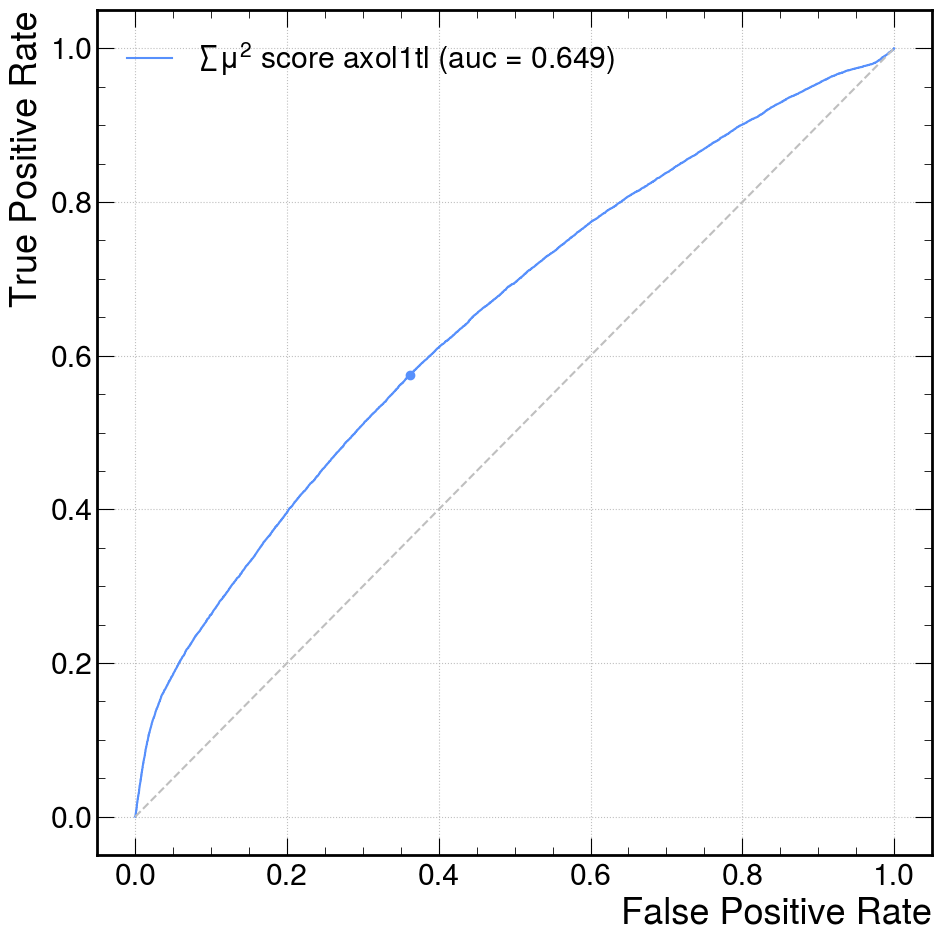

Fit gamma  0.4444444444444444


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_activation_13    │ (None, 57)        │          1 │ input_layer_28[0… │
│ (TQActivation)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_26         │ (None, 32)        │      1,859 │ tq_activation_13… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ tq_dense_26[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_27         │ (None, 16)        │        531 │ batch_normalizat… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ tq_dense_27[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (TQDense)    │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (TQDense) │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_14         │ (None, 8)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bernoulli           │ (None, 8)         │          0 │ sampling_14[0][0] │
│ (BernoulliSampling) │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,861 (11.18 KB)

 Trainable params: 2,765 (10.80 KB)

 Non-trainable params: 96 (384.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,761 (10.79 KB)

 Trainable params: 2,665 (10.41 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/10


W0000 00:00:1736791818.151562 94878566 loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/cond/branch_executed/_139


586/586 - 6s - 10ms/step - bops: 84492.0938 - kl_loss: 2.2790 - loss: 84494.5391 - mi_loss: 0.1698 - reconstruction_loss: 0.0206
Epoch 2/10
586/586 - 3s - 5ms/step - bops: 83484.5703 - kl_loss: 0.2347 - loss: 83484.8359 - mi_loss: 0.0452 - reconstruction_loss: 0.0116
Epoch 3/10
586/586 - 3s - 5ms/step - bops: 82757.3203 - kl_loss: 0.0908 - loss: 82757.4766 - mi_loss: 0.0184 - reconstruction_loss: 0.0115
Epoch 4/10
586/586 - 3s - 5ms/step - bops: 82187.4219 - kl_loss: 0.0485 - loss: 82187.5000 - mi_loss: 0.0106 - reconstruction_loss: 0.0115
Epoch 5/10
586/586 - 3s - 5ms/step - bops: 81718.5469 - kl_loss: 0.0300 - loss: 81718.5859 - mi_loss: 0.0068 - reconstruction_loss: 0.0115
Epoch 6/10
586/586 - 3s - 5ms/step - bops: 81320.1641 - kl_loss: 0.0201 - loss: 81320.2109 - mi_loss: 0.0047 - reconstruction_loss: 0.0115
Epoch 7/10
586/586 - 3s - 5ms/step - bops: 80973.8125 - kl_loss: 0.0142 - loss: 80973.8438 - mi_loss: 0.0033 - reconstruction_loss: 0.0115
Epoch 8/10
586/586 - 3s - 5ms/step - 

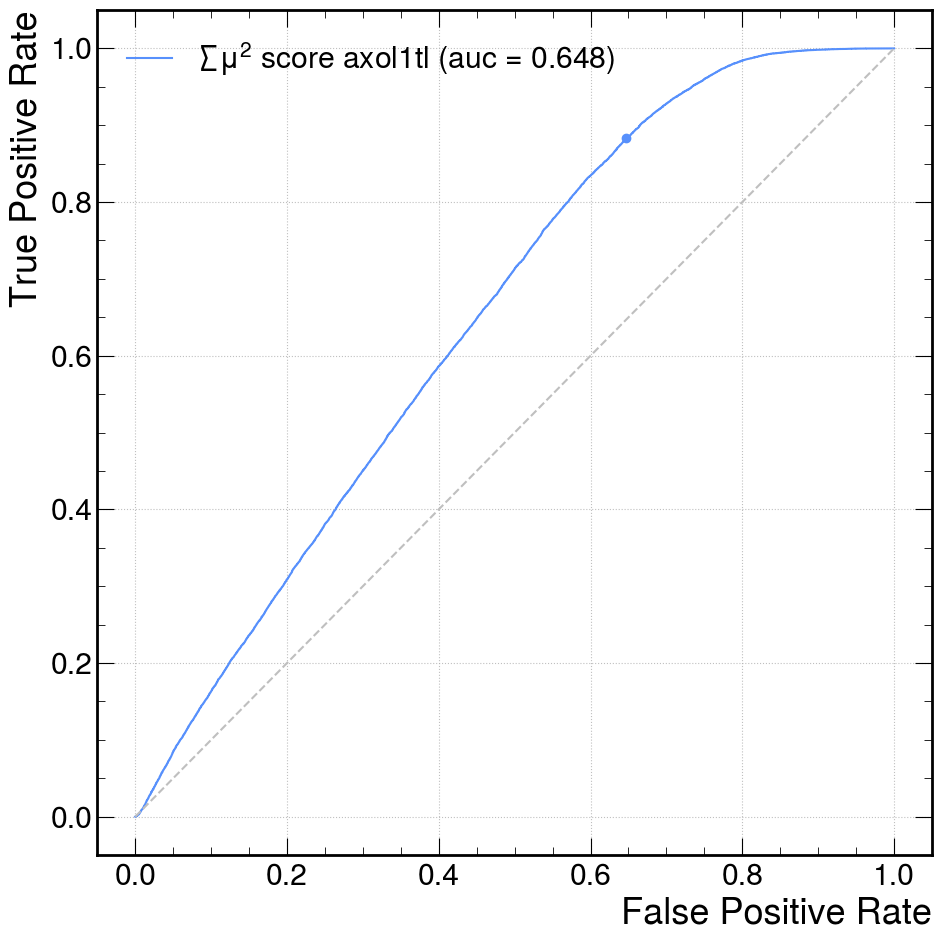

Fit gamma  0.5555555555555556


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_activation_14    │ (None, 57)        │          1 │ input_layer_30[0… │
│ (TQActivation)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_28         │ (None, 32)        │      1,859 │ tq_activation_14… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ tq_dense_28[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_29         │ (None, 16)        │        531 │ batch_normalizat… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ tq_dense_29[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (TQDense)    │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (TQDense) │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_15         │ (None, 8)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bernoulli           │ (None, 8)         │          0 │ sampling_15[0][0] │
│ (BernoulliSampling) │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,861 (11.18 KB)

 Trainable params: 2,765 (10.80 KB)

 Non-trainable params: 96 (384.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,761 (10.79 KB)

 Trainable params: 2,665 (10.41 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/10


W0000 00:00:1736791849.518311 94878566 loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/map/while/body/_141/map/while/cond/branch_executed/_777


586/586 - 7s - 11ms/step - bops: 84492.0938 - kl_loss: 2.6343 - loss: 84494.9844 - mi_loss: 0.2375 - reconstruction_loss: 0.0196
Epoch 2/10
586/586 - 3s - 5ms/step - bops: 83484.5703 - kl_loss: 0.2401 - loss: 83484.8594 - mi_loss: 0.0686 - reconstruction_loss: 0.0116
Epoch 3/10
586/586 - 3s - 5ms/step - bops: 82757.3203 - kl_loss: 0.1376 - loss: 82757.5703 - mi_loss: 0.0390 - reconstruction_loss: 0.0115
Epoch 4/10
586/586 - 3s - 5ms/step - bops: 82187.4219 - kl_loss: 0.0938 - loss: 82187.5391 - mi_loss: 0.0276 - reconstruction_loss: 0.0115
Epoch 5/10
586/586 - 3s - 5ms/step - bops: 81718.5469 - kl_loss: 0.0692 - loss: 81718.6406 - mi_loss: 0.0196 - reconstruction_loss: 0.0115
Epoch 6/10
586/586 - 3s - 5ms/step - bops: 81320.1641 - kl_loss: 0.0533 - loss: 81320.2578 - mi_loss: 0.0148 - reconstruction_loss: 0.0115
Epoch 7/10
586/586 - 3s - 5ms/step - bops: 80973.8125 - kl_loss: 0.0423 - loss: 80973.8750 - mi_loss: 0.0124 - reconstruction_loss: 0.0115
Epoch 8/10
586/586 - 3s - 5ms/step - 

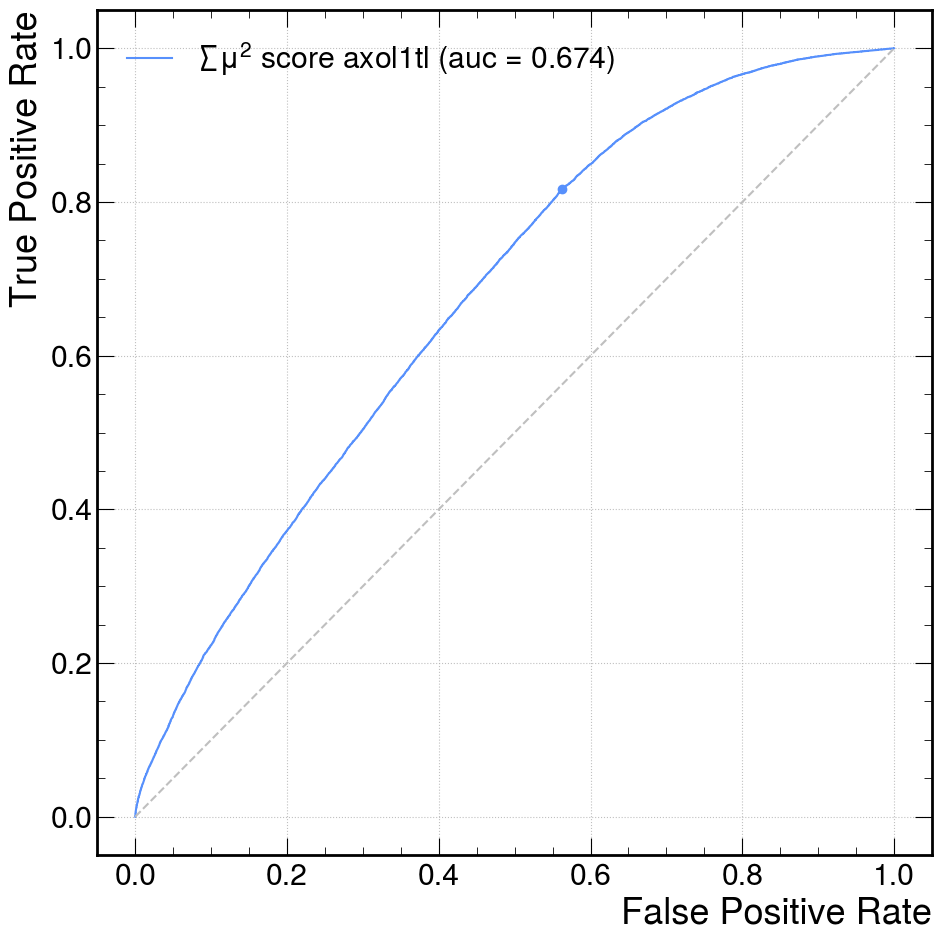

Fit gamma  0.6666666666666666


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32      │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_activation_15    │ (None, 57)        │          1 │ input_layer_32[0… │
│ (TQActivation)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_30         │ (None, 32)        │      1,859 │ tq_activation_15… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ tq_dense_30[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_31         │ (None, 16)        │        531 │ batch_normalizat… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ tq_dense_31[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (TQDense)    │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (TQDense) │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_16         │ (None, 8)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bernoulli           │ (None, 8)         │          0 │ sampling_16[0][0] │
│ (BernoulliSampling) │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,861 (11.18 KB)

 Trainable params: 2,765 (10.80 KB)

 Non-trainable params: 96 (384.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,761 (10.79 KB)

 Trainable params: 2,665 (10.41 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/10


W0000 00:00:1736791881.118679 94878566 loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/map/while/body/_141/map/while/cond/branch_executed/_777


586/586 - 6s - 10ms/step - bops: 84492.0938 - kl_loss: 10.7086 - loss: 84503.2656 - mi_loss: 0.4308 - reconstruction_loss: 0.0185
Epoch 2/10
586/586 - 3s - 5ms/step - bops: 83484.5703 - kl_loss: 1.4735 - loss: 83486.2500 - mi_loss: 0.2169 - reconstruction_loss: 0.0115
Epoch 3/10
586/586 - 3s - 5ms/step - bops: 82757.3203 - kl_loss: 0.8109 - loss: 82758.2344 - mi_loss: 0.0952 - reconstruction_loss: 0.0115
Epoch 4/10
586/586 - 3s - 5ms/step - bops: 82187.4219 - kl_loss: 0.5756 - loss: 82188.0234 - mi_loss: 0.0397 - reconstruction_loss: 0.0115
Epoch 5/10
586/586 - 3s - 5ms/step - bops: 81718.5469 - kl_loss: 0.4547 - loss: 81719.0312 - mi_loss: 0.0196 - reconstruction_loss: 0.0115
Epoch 6/10
586/586 - 3s - 5ms/step - bops: 81320.1641 - kl_loss: 0.3748 - loss: 81320.5703 - mi_loss: 0.0098 - reconstruction_loss: 0.0115
Epoch 7/10
586/586 - 3s - 5ms/step - bops: 80973.8125 - kl_loss: 0.3191 - loss: 80974.1641 - mi_loss: 0.0058 - reconstruction_loss: 0.0115
Epoch 8/10
586/586 - 3s - 5ms/step -

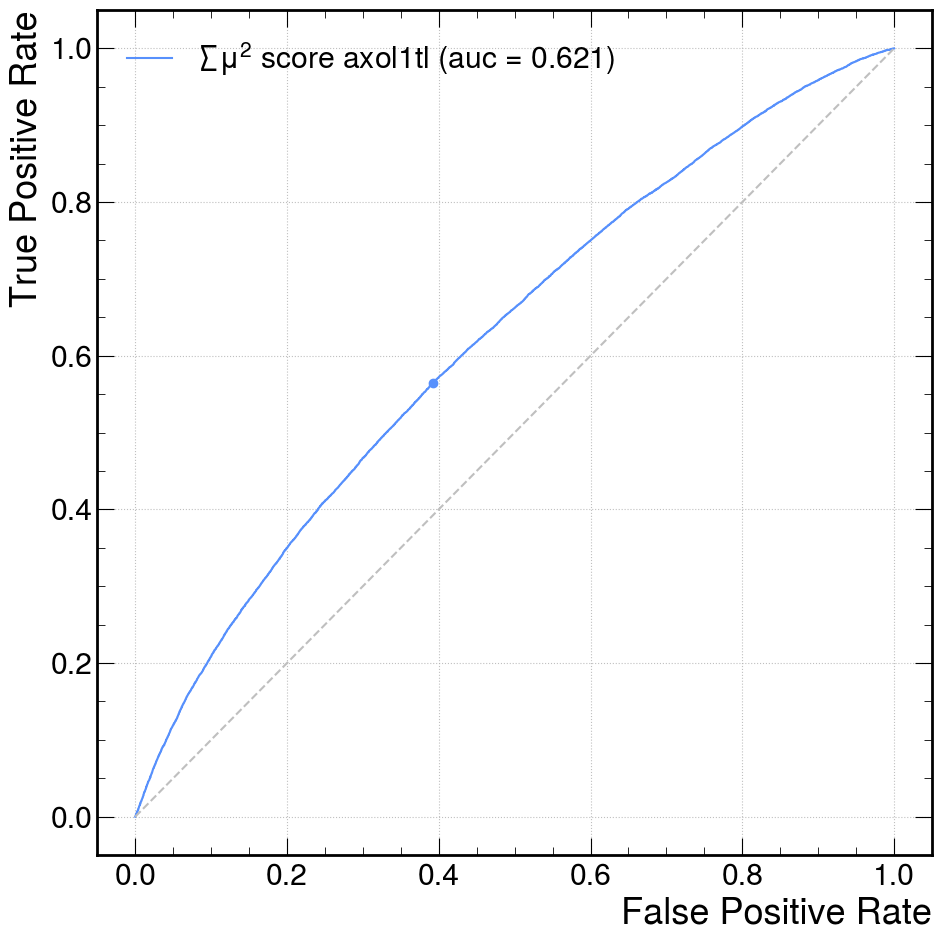

Fit gamma  0.7777777777777777


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_activation_16    │ (None, 57)        │          1 │ input_layer_34[0… │
│ (TQActivation)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_32         │ (None, 32)        │      1,859 │ tq_activation_16… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ tq_dense_32[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_33         │ (None, 16)        │        531 │ batch_normalizat… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ tq_dense_33[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (TQDense)    │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (TQDense) │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_17         │ (None, 8)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bernoulli           │ (None, 8)         │          0 │ sampling_17[0][0] │
│ (BernoulliSampling) │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,861 (11.18 KB)

 Trainable params: 2,765 (10.80 KB)

 Non-trainable params: 96 (384.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,761 (10.79 KB)

 Trainable params: 2,665 (10.41 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/10


W0000 00:00:1736791913.030400 94878566 loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/map/while/body/_141/map/while/cond/branch_executed/_777


586/586 - 7s - 11ms/step - bops: 84492.0938 - kl_loss: 2.8580 - loss: 84495.3359 - mi_loss: 0.3951 - reconstruction_loss: 0.0193
Epoch 2/10
586/586 - 3s - 5ms/step - bops: 83484.5703 - kl_loss: 0.3705 - loss: 83485.1016 - mi_loss: 0.1433 - reconstruction_loss: 0.0116
Epoch 3/10
586/586 - 3s - 5ms/step - bops: 82757.3203 - kl_loss: 0.1513 - loss: 82757.6016 - mi_loss: 0.0662 - reconstruction_loss: 0.0115
Epoch 4/10
586/586 - 3s - 5ms/step - bops: 82187.4219 - kl_loss: 0.0825 - loss: 82187.5625 - mi_loss: 0.0364 - reconstruction_loss: 0.0115
Epoch 5/10
586/586 - 3s - 5ms/step - bops: 81718.5469 - kl_loss: 0.0519 - loss: 81718.6328 - mi_loss: 0.0228 - reconstruction_loss: 0.0115
Epoch 6/10
586/586 - 3s - 5ms/step - bops: 81320.1641 - kl_loss: 0.0357 - loss: 81320.2422 - mi_loss: 0.0154 - reconstruction_loss: 0.0115
Epoch 7/10
586/586 - 3s - 5ms/step - bops: 80973.8125 - kl_loss: 0.0255 - loss: 80973.8672 - mi_loss: 0.0117 - reconstruction_loss: 0.0115
Epoch 8/10
586/586 - 3s - 5ms/step - 

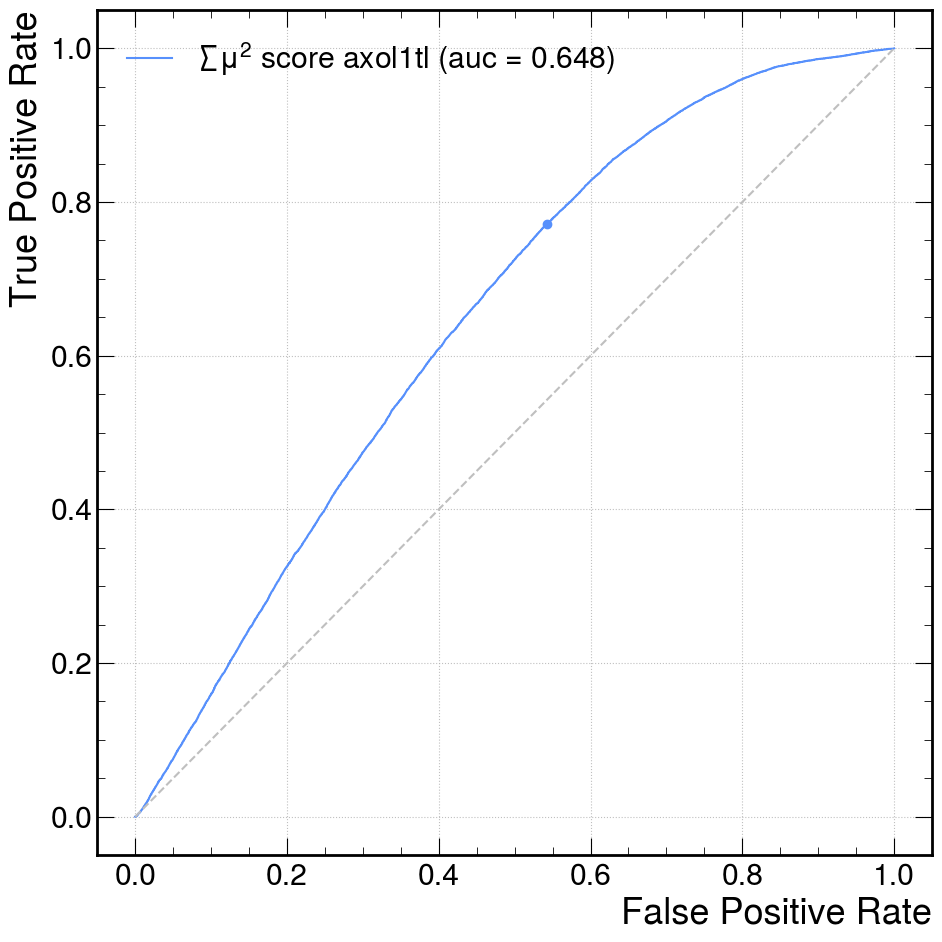

Fit gamma  0.8888888888888888


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36      │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_activation_17    │ (None, 57)        │          1 │ input_layer_36[0… │
│ (TQActivation)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_34         │ (None, 32)        │      1,859 │ tq_activation_17… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ tq_dense_34[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_35         │ (None, 16)        │        531 │ batch_normalizat… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ tq_dense_35[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (TQDense)    │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (TQDense) │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_18         │ (None, 8)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bernoulli           │ (None, 8)         │          0 │ sampling_18[0][0] │
│ (BernoulliSampling) │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,861 (11.18 KB)

 Trainable params: 2,765 (10.80 KB)

 Non-trainable params: 96 (384.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,761 (10.79 KB)

 Trainable params: 2,665 (10.41 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/10


W0000 00:00:1736791944.617479 94878566 loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/map/while/body/_141/map/while/cond/branch_executed/_777


586/586 - 6s - 10ms/step - bops: 84492.0938 - kl_loss: 3.0339 - loss: 84495.5469 - mi_loss: 0.4104 - reconstruction_loss: 0.0196
Epoch 2/10
586/586 - 3s - 5ms/step - bops: 83484.5703 - kl_loss: 0.2524 - loss: 83484.9062 - mi_loss: 0.1009 - reconstruction_loss: 0.0116
Epoch 3/10
586/586 - 3s - 5ms/step - bops: 82757.3203 - kl_loss: 0.0888 - loss: 82757.5000 - mi_loss: 0.0426 - reconstruction_loss: 0.0115
Epoch 4/10
586/586 - 3s - 5ms/step - bops: 82187.4219 - kl_loss: 0.0464 - loss: 82187.5078 - mi_loss: 0.0215 - reconstruction_loss: 0.0115
Epoch 5/10
586/586 - 3s - 5ms/step - bops: 81718.5469 - kl_loss: 0.0293 - loss: 81718.5938 - mi_loss: 0.0153 - reconstruction_loss: 0.0115
Epoch 6/10
586/586 - 3s - 5ms/step - bops: 81320.1641 - kl_loss: 0.0200 - loss: 81320.2188 - mi_loss: 0.0106 - reconstruction_loss: 0.0115
Epoch 7/10
586/586 - 3s - 5ms/step - bops: 80973.8125 - kl_loss: 0.0144 - loss: 80973.8594 - mi_loss: 0.0071 - reconstruction_loss: 0.0115
Epoch 8/10
586/586 - 3s - 5ms/step - 

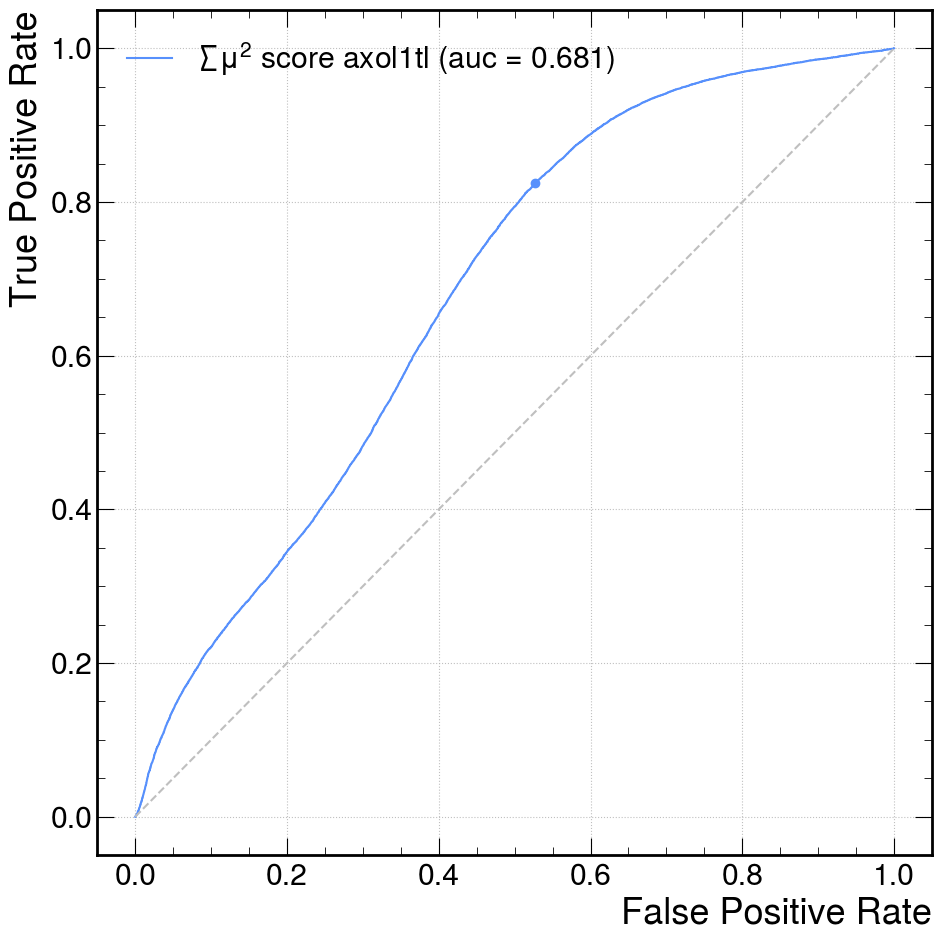

Fit gamma  1.0


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_activation_18    │ (None, 57)        │          1 │ input_layer_38[0… │
│ (TQActivation)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_36         │ (None, 32)        │      1,859 │ tq_activation_18… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ tq_dense_36[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_37         │ (None, 16)        │        531 │ batch_normalizat… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ tq_dense_37[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (TQDense)    │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (TQDense) │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_19         │ (None, 8)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bernoulli           │ (None, 8)         │          0 │ sampling_19[0][0] │
│ (BernoulliSampling) │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,861 (11.18 KB)

 Trainable params: 2,765 (10.80 KB)

 Non-trainable params: 96 (384.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_39 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,761 (10.79 KB)

 Trainable params: 2,665 (10.41 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/10


W0000 00:00:1736791977.039559 94878566 loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/map/while/body/_141/map/while/cond/branch_executed/_777


586/586 - 7s - 11ms/step - bops: 84492.0938 - kl_loss: 2.5114 - loss: 84495.0234 - mi_loss: 0.4361 - reconstruction_loss: 0.0206
Epoch 2/10
586/586 - 3s - 5ms/step - bops: 83484.5703 - kl_loss: 0.1226 - loss: 83484.7656 - mi_loss: 0.0806 - reconstruction_loss: 0.0116
Epoch 3/10
586/586 - 3s - 5ms/step - bops: 82757.3203 - kl_loss: 0.0312 - loss: 82757.4141 - mi_loss: 0.0269 - reconstruction_loss: 0.0115
Epoch 4/10
586/586 - 3s - 5ms/step - bops: 82187.4219 - kl_loss: 0.0147 - loss: 82187.4766 - mi_loss: 0.0135 - reconstruction_loss: 0.0115
Epoch 5/10
586/586 - 3s - 5ms/step - bops: 81718.5469 - kl_loss: 0.0089 - loss: 81718.5781 - mi_loss: 0.0088 - reconstruction_loss: 0.0115
Epoch 6/10
586/586 - 3s - 5ms/step - bops: 81320.1641 - kl_loss: 0.0061 - loss: 81320.2109 - mi_loss: 0.0056 - reconstruction_loss: 0.0115
Epoch 7/10
586/586 - 3s - 5ms/step - bops: 80973.8125 - kl_loss: 0.0044 - loss: 80973.8438 - mi_loss: 0.0045 - reconstruction_loss: 0.0115
Epoch 8/10
586/586 - 3s - 5ms/step - 

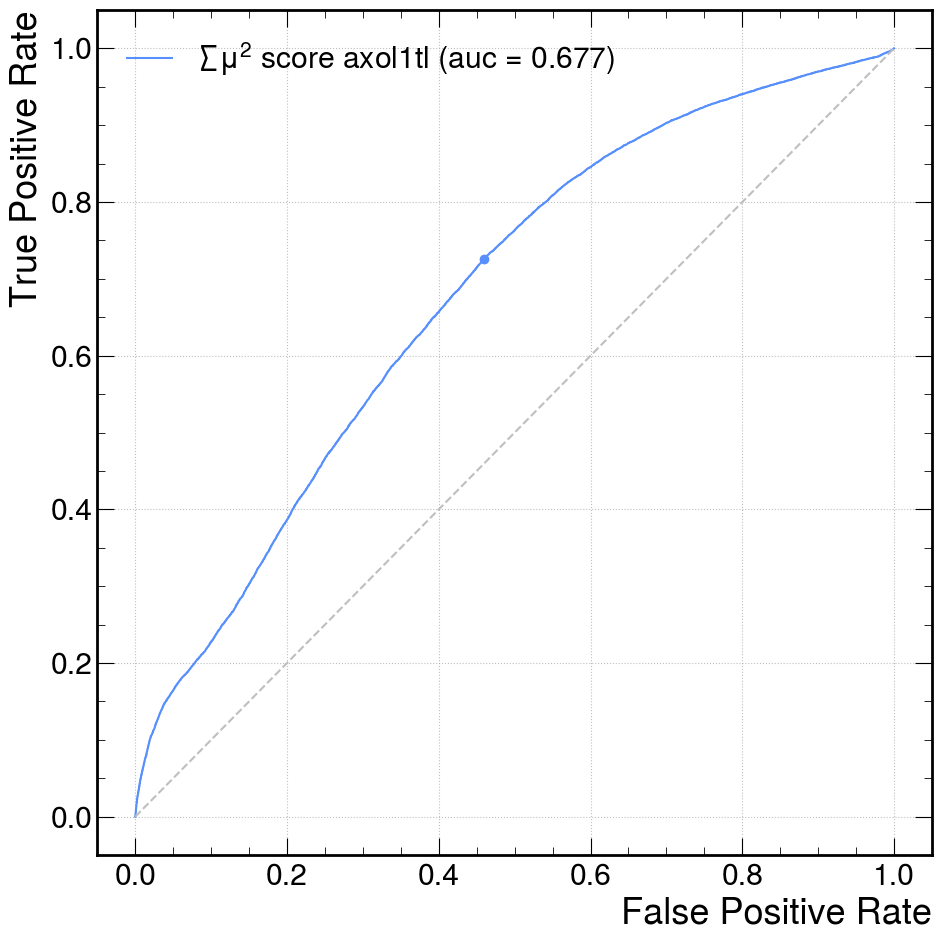

In [17]:
normal_data_list = []
abnormal_data_list = []
for gamma in np.linspace(0, 1, 10):
    MiVAE_model = MiVAE(
        verbose=2,
        activation="tanh",
        use_qkeras=False,
        use_quantflow=True,
        use_batchnorm=True,
        use_quantized_sigmoid=False,
        batch_size=256,
        beta_param=1,
        alpha=1,
        drop_out=0.0,
        epoch=10,
        gamma=round(gamma,1),
        num_samples=10,
        hidden_layers=[32, 16],
        latent_dims=8,
        learning_rate=0.001,
        optimizer="Adam",
        patience=100,
        mi_loss=True,
        run_eagerly=False
    )
    print("Fit gamma ", gamma)
    history = MiVAE_model.fit(X_train, nPV_train)

    # get data
    mean_abnormal_score = MiVAE_model.get_mean(abnormal_data_test_scaled).numpy()
    mean_abnormal_score = np.sum(mean_abnormal_score**2, axis=1)
    mean_normal_score = MiVAE_model.get_mean(X_test).numpy()
    mean_normal_score = np.sum(mean_normal_score**2, axis=1)

    # generate plots for the ROC curves
    y_test = np.concatenate((np.ones(len(mean_abnormal_score)), np.zeros(len(mean_normal_score))))
    thr = plot_roc(y_test, np.concatenate((mean_abnormal_score, mean_normal_score)), name=r"$\sum \mu^2$ score axol1tl")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
    plt.show()
    plt.close()

    normal_data_list.append(mean_normal_score)
    abnormal_data_list.append(mean_abnormal_score)


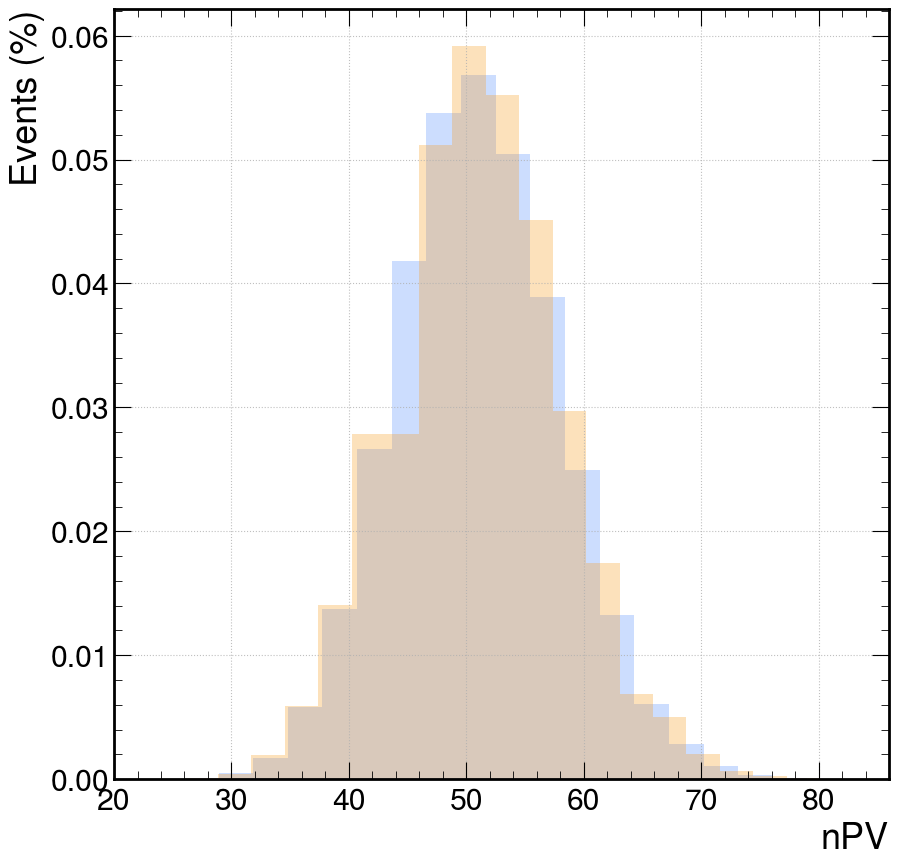

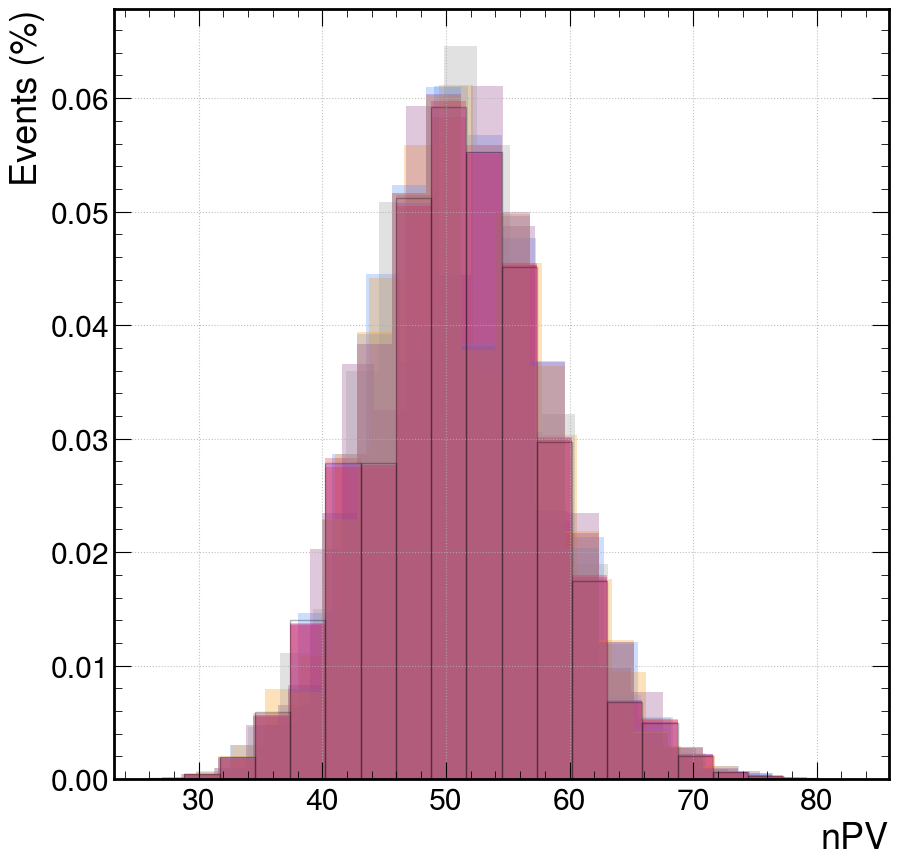

In [32]:
bins = 20

plt.hist(nPV_test, bins=bins, density=True, alpha=0.3)
plt.hist(nPV_abnormal_test, bins=bins, density=True, alpha=0.3)

plt.xlabel("nPV")
plt.ylabel("Events (%)")

plt.legend(loc='best', ncol=2, prop={'size': 8})
plt.grid(True)

plt.show()
plt.close()

for i, gamma in enumerate(np.linspace(0, 1, 10)):

    y_test = np.concatenate((np.ones(len(abnormal_data_list[i])), np.zeros(len(normal_data_list[i]))))
    thr, auc_value = plot_roc(y_test, np.concatenate((abnormal_data_list[i], normal_data_list[i])), name=r"$\sum \mu^2$ score axol1tl", plot=False)

    # generate plots for pile-up studies
    #plt.hist(nPV_test[normal_data_list[i] > thr], bins=bins, density=True, alpha=0.3)
    plt.hist(nPV_abnormal_test[abnormal_data_list[i] > thr], bins=bins, density=True, alpha=0.3)

#plt.hist(nPV_test, bins=bins, density=True, fill=False, alpha=0.3, color="black")
plt.hist(nPV_abnormal_test, bins=bins, density=True, fill=False, alpha=0.3, color="black")

plt.xlabel("nPV")
plt.ylabel("Events (%)")

plt.legend(loc='best', ncol=2, prop={'size': 8})
plt.grid(True)

plt.show()

In [7]:
# train the model
MiVAE_model = MiVAE(
    verbose=2,
    activation="tanh",
    use_qkeras=False,
    use_quantflow=True,
    use_batchnorm=True,
    use_quantized_sigmoid=False,
    batch_size=256,
    beta_param=1,
    drop_out=0.0,
    epoch=20,
    init_quantized_bits=16,
    alpha=1,
    gamma=10,
    num_samples=10,
    hidden_layers=[32, 16],
    latent_dims=8,
    learning_rate=0.0001,
    optimizer="Adam",
    patience=100,
    mi_loss=True,
    run_eagerly=False
)
history = MiVAE_model.fit(X_train, nPV_train)

MiVAE_model_gamma_zero = MiVAE(
    verbose=2,
    activation="relu",
    use_qkeras=True,
    use_quantflow=False,
    use_batchnorm=True,
    use_quantized_sigmoid=False,
    batch_size=256,
    beta_param=1,
    drop_out=0.0,
    epoch=20,
    gamma=0,
    num_samples=10,
    hidden_layers=[32, 16],
    latent_dims=8,
    learning_rate=0.0001,
    optimizer="Adam",
    mi_loss=False,
    run_eagerly=False
)
history_gamma_zero = MiVAE_model_gamma_zero.fit(X_train, nPV_train)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_activation_7     │ (None, 57)        │          1 │ input_layer_14[0… │
│ (TQActivation)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_14         │ (None, 32)        │      1,859 │ tq_activation_7[… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ tq_dense_14[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_15         │ (None, 16)        │        531 │ batch_normalizat… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ tq_dense_15[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (TQDense)    │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (TQDense) │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_7          │ (None, 8)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bernoulli           │ (None, 8)         │          0 │ sampling_7[0][0]  │
│ (BernoulliSampling) │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,861 (11.18 KB)

 Trainable params: 2,765 (10.80 KB)

 Non-trainable params: 96 (384.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,761 (10.79 KB)

 Trainable params: 2,665 (10.41 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/20


W0000 00:00:1736791034.309249 94878566 loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/map/while/body/_141/map/while/cond/branch_executed/_777


586/586 - 6s - 11ms/step - bops: 42510.0156 - kl_loss: 9.6401 - loss: 42526.9375 - mi_loss: 7.2150 - reconstruction_loss: 0.0860
Epoch 2/20
586/586 - 3s - 5ms/step - bops: 42409.2734 - kl_loss: 6.5508 - loss: 42422.7422 - mi_loss: 6.8838 - reconstruction_loss: 0.0344
Epoch 3/20
586/586 - 3s - 5ms/step - bops: 42336.5352 - kl_loss: 5.2131 - loss: 42348.4062 - mi_loss: 6.6086 - reconstruction_loss: 0.0184
Epoch 4/20
586/586 - 3s - 5ms/step - bops: 42279.5547 - kl_loss: 4.4128 - loss: 42290.2930 - mi_loss: 6.3330 - reconstruction_loss: 0.0147
Epoch 5/20
586/586 - 3s - 5ms/step - bops: 42232.6641 - kl_loss: 3.8568 - loss: 42242.6992 - mi_loss: 6.1663 - reconstruction_loss: 0.0133
Epoch 6/20
586/586 - 3s - 5ms/step - bops: 42192.8320 - kl_loss: 3.4483 - loss: 42202.1914 - mi_loss: 5.8953 - reconstruction_loss: 0.0127
Epoch 7/20
586/586 - 3s - 5ms/step - bops: 42158.1992 - kl_loss: 3.1233 - loss: 42167.0859 - mi_loss: 5.7331 - reconstruction_loss: 0.0123
Epoch 8/20
586/586 - 3s - 5ms/step - 

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_activation        │ (None, 57)        │          0 │ input_layer_16[0… │
│ (QActivation)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_dense (QDense)    │ (None, 32)        │      1,856 │ q_activation[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ q_dense[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_dense_1 (QDense)  │ (None, 16)        │        528 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ q_dense_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (QDense)     │ (None, 8)         │        136 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (QDense)  │ (None, 8)         │        136 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_8          │ (None, 8)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,848 (11.12 KB)

 Trainable params: 2,752 (10.75 KB)

 Non-trainable params: 96 (384.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,761 (10.79 KB)

 Trainable params: 2,665 (10.41 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/20


W0000 00:00:1736791093.957359 94878566 loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/encoder_1/q_dense_1_2/cond_1/branch_executed/_147


586/586 - 3s - 5ms/step - bops: 0.0000e+00 - kl_loss: 7.2524 - loss: 7.3438 - mi_loss: 0.0000e+00 - reconstruction_loss: 0.0914
Epoch 2/20
586/586 - 1s - 1ms/step - bops: 0.0000e+00 - kl_loss: 3.8626 - loss: 3.9131 - mi_loss: 0.0000e+00 - reconstruction_loss: 0.0505
Epoch 3/20
586/586 - 1s - 1ms/step - bops: 0.0000e+00 - kl_loss: 2.7085 - loss: 2.7382 - mi_loss: 0.0000e+00 - reconstruction_loss: 0.0297
Epoch 4/20
586/586 - 1s - 1ms/step - bops: 0.0000e+00 - kl_loss: 2.0571 - loss: 2.0781 - mi_loss: 0.0000e+00 - reconstruction_loss: 0.0210
Epoch 5/20
586/586 - 1s - 1ms/step - bops: 0.0000e+00 - kl_loss: 1.6336 - loss: 1.6511 - mi_loss: 0.0000e+00 - reconstruction_loss: 0.0176
Epoch 6/20
586/586 - 1s - 1ms/step - bops: 0.0000e+00 - kl_loss: 1.3302 - loss: 1.3460 - mi_loss: 0.0000e+00 - reconstruction_loss: 0.0158
Epoch 7/20
586/586 - 1s - 1ms/step - bops: 0.0000e+00 - kl_loss: 1.1060 - loss: 1.1208 - mi_loss: 0.0000e+00 - reconstruction_loss: 0.0149
Epoch 8/20
586/586 - 1s - 1ms/step - b

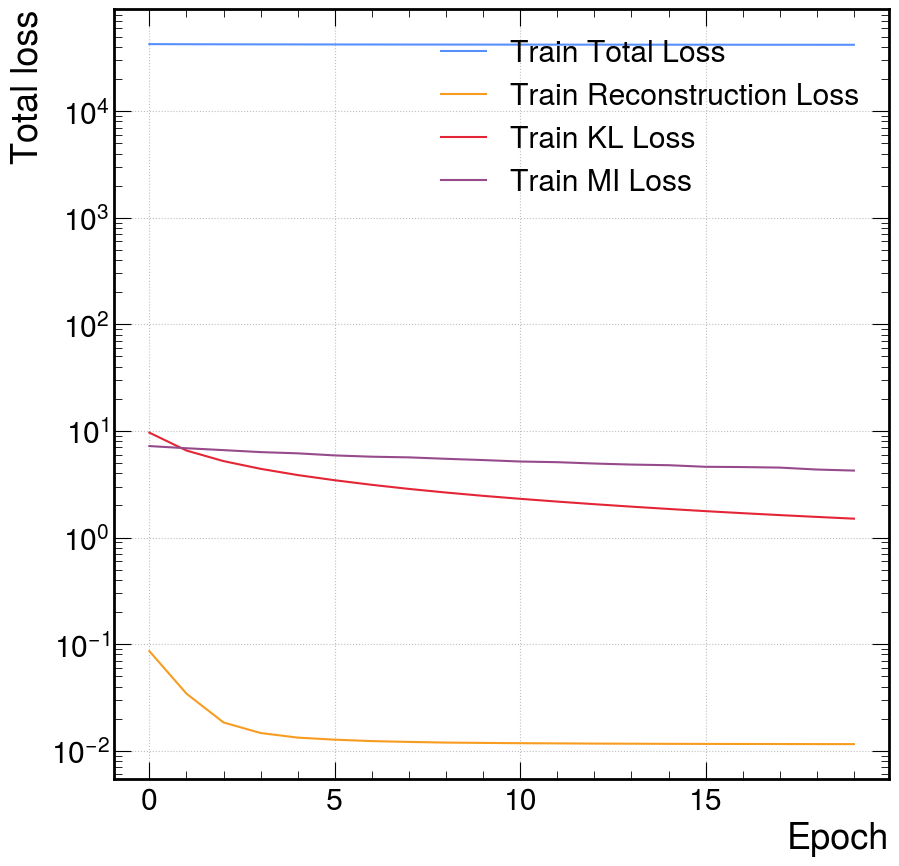

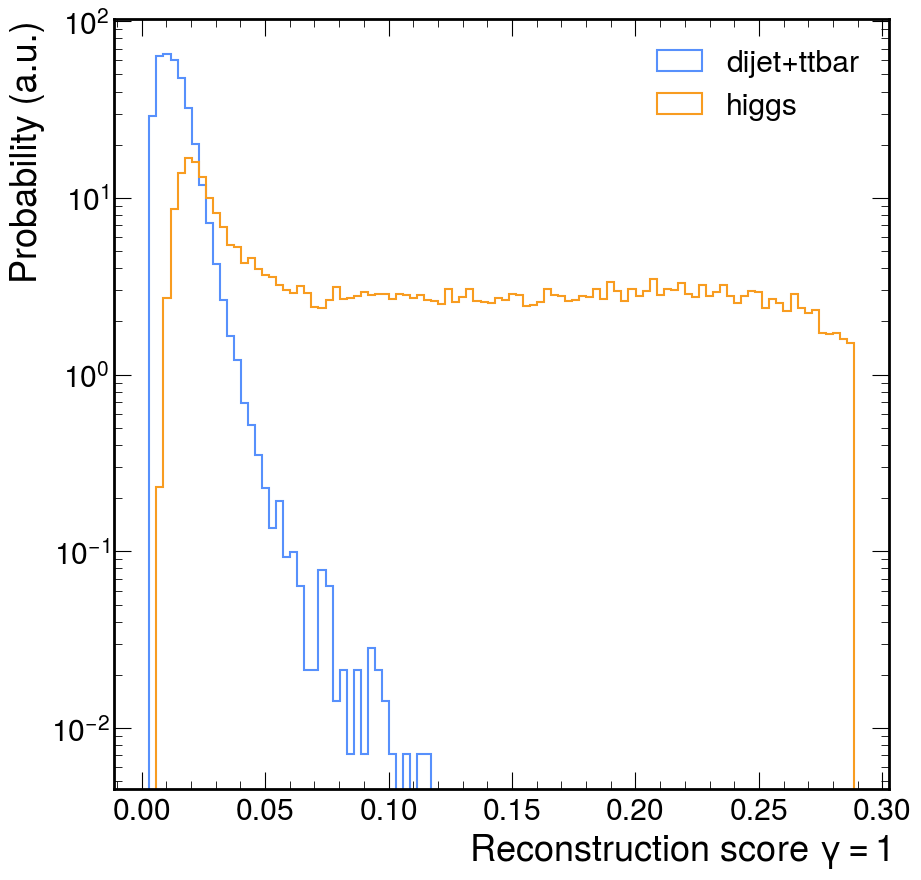

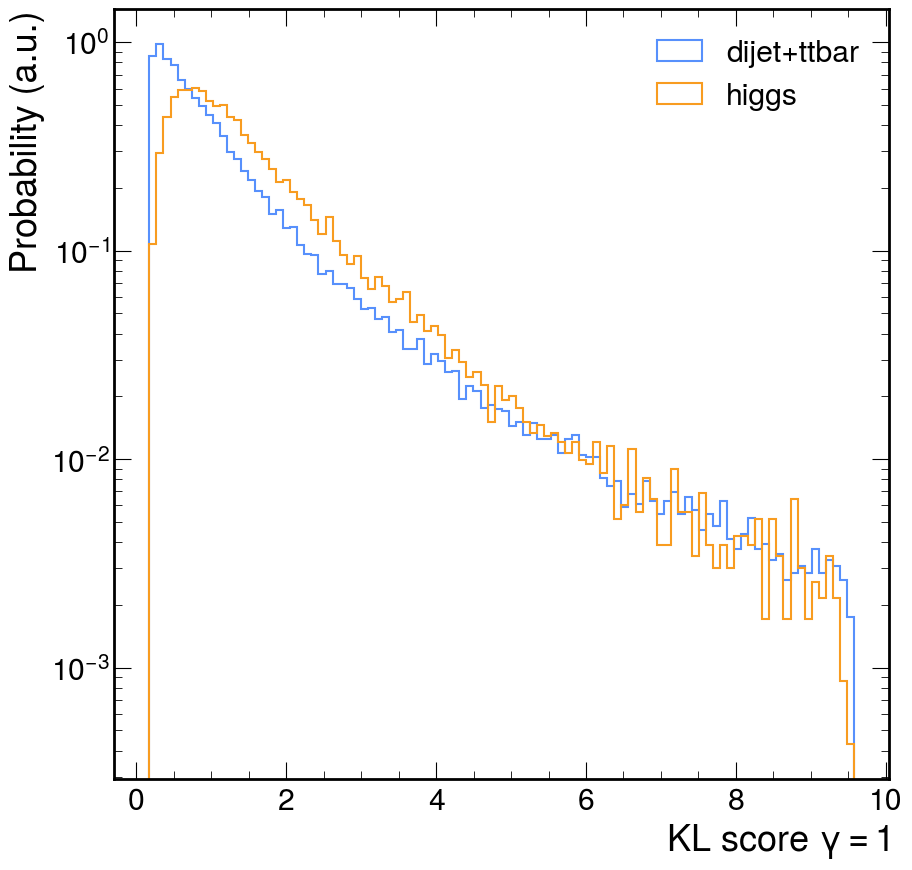

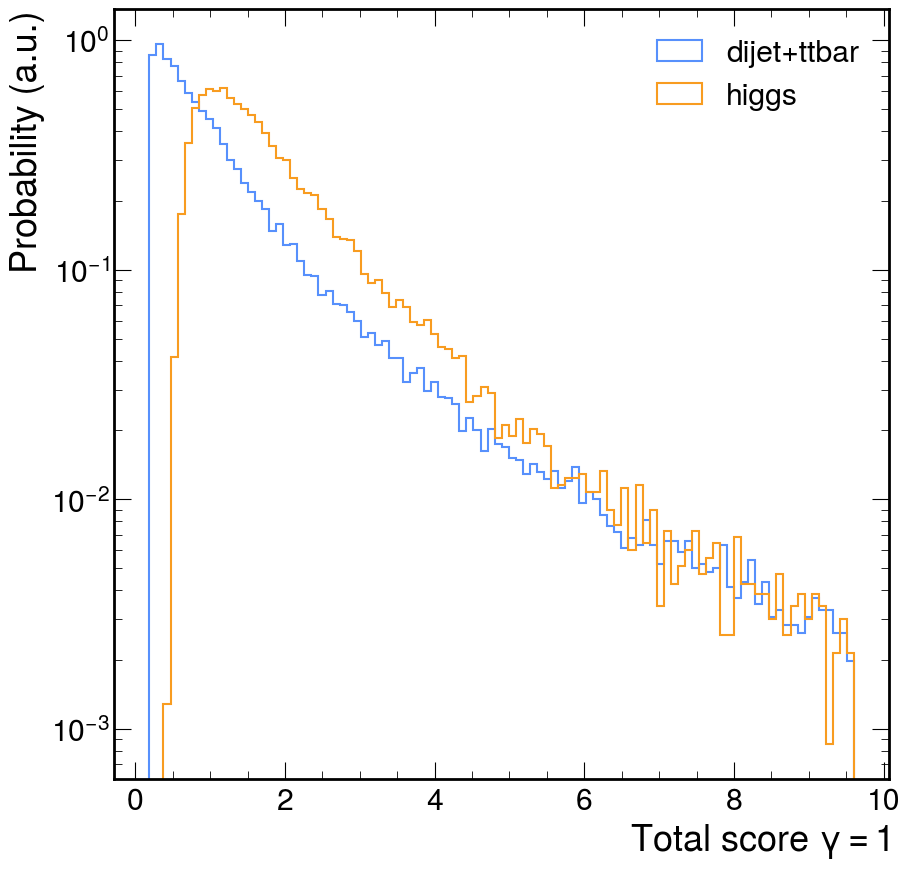

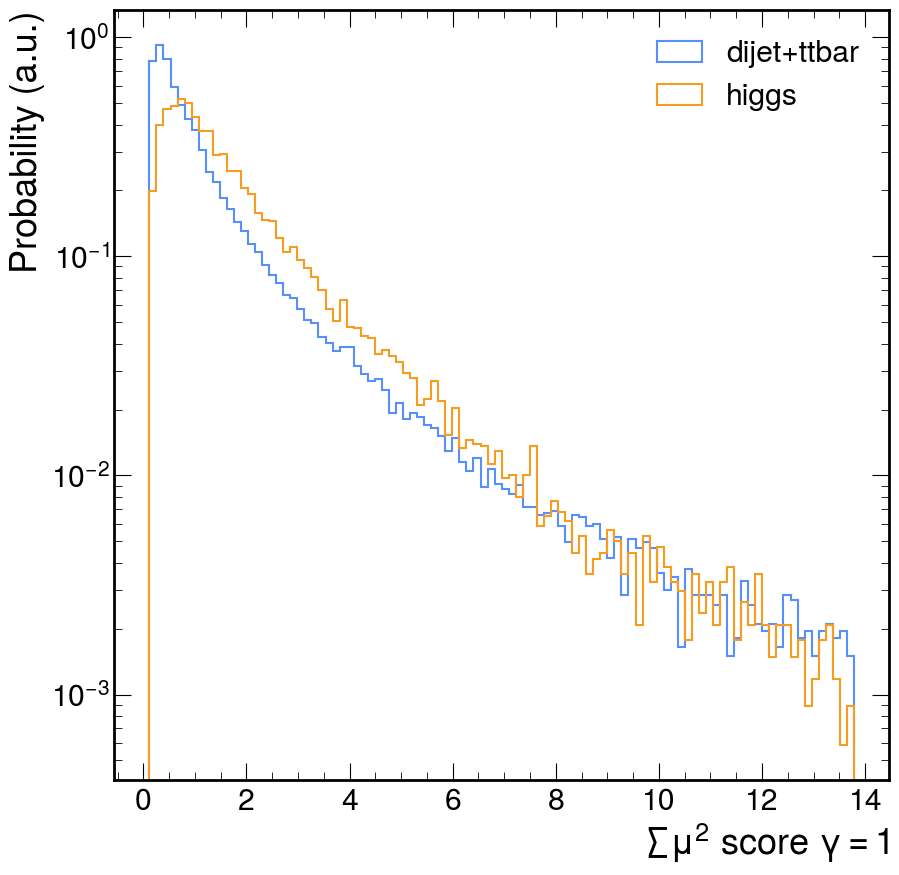

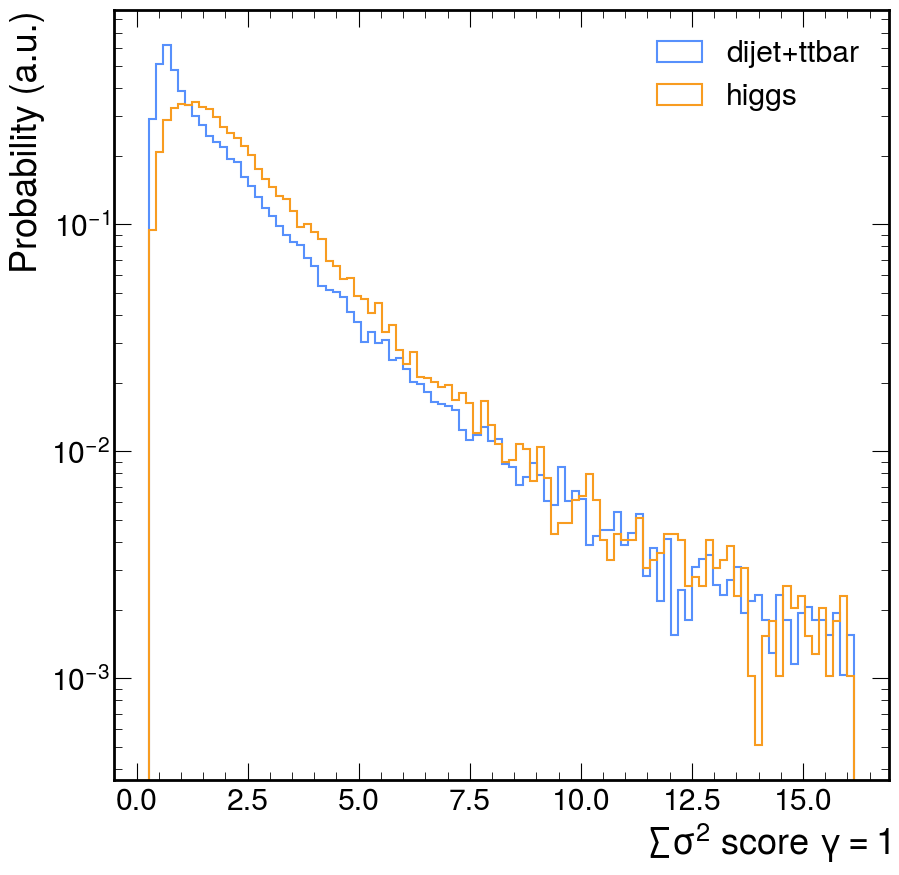

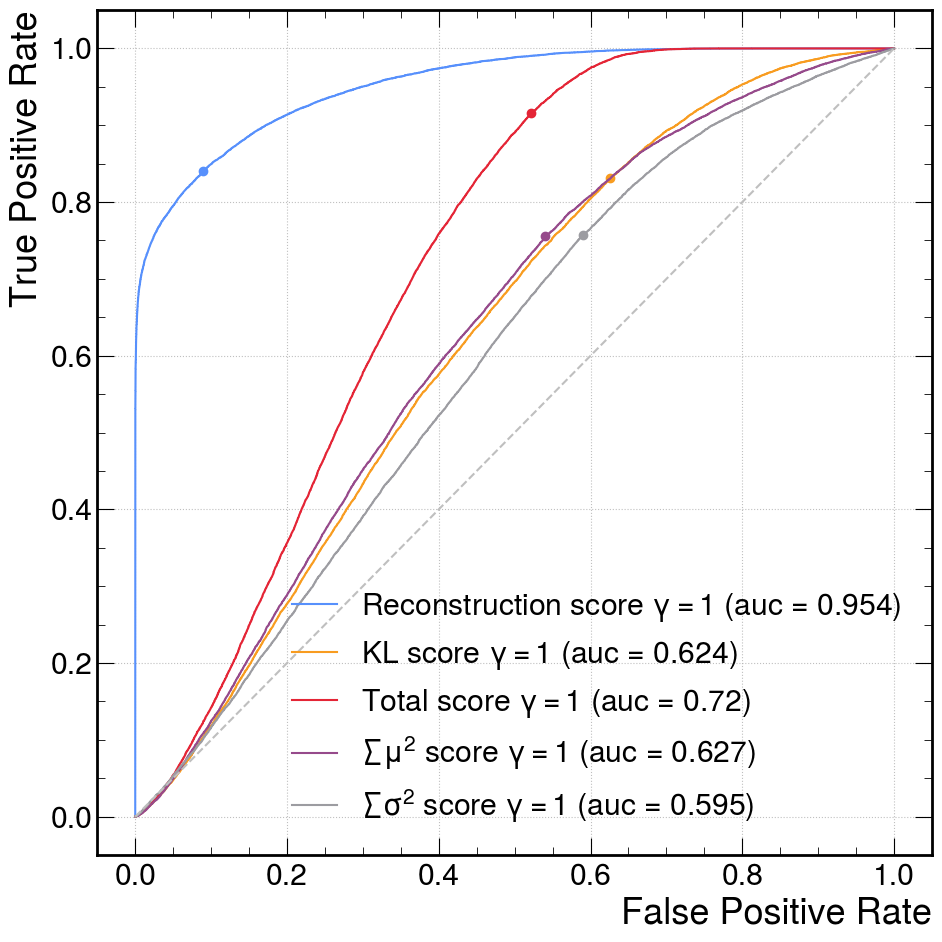

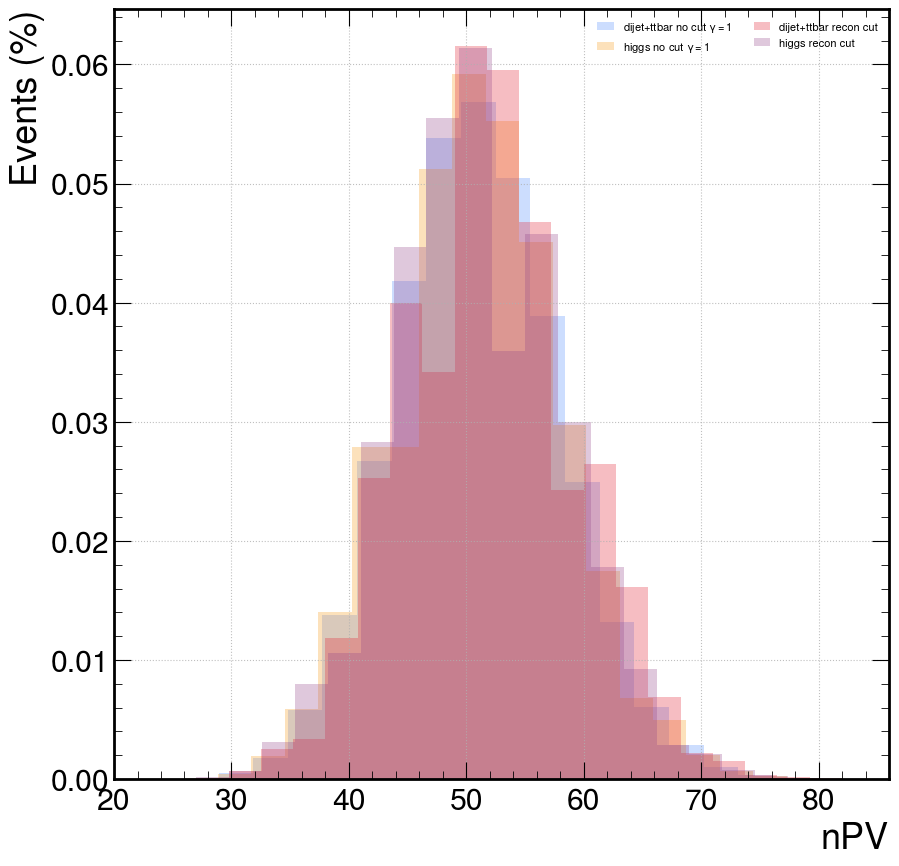

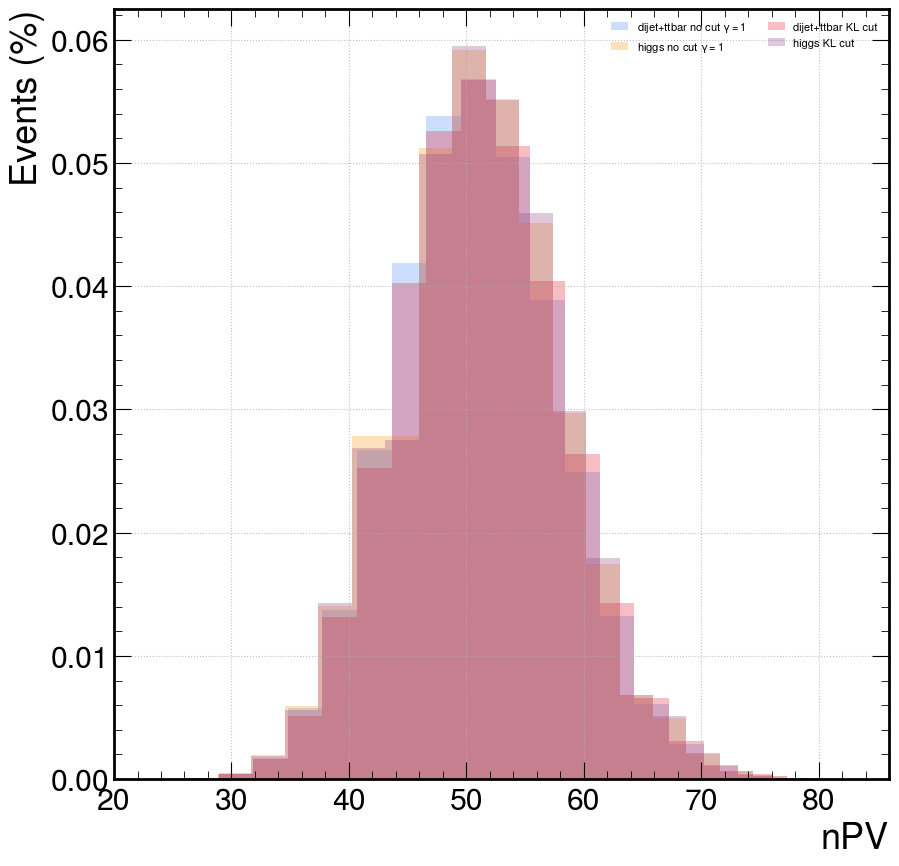

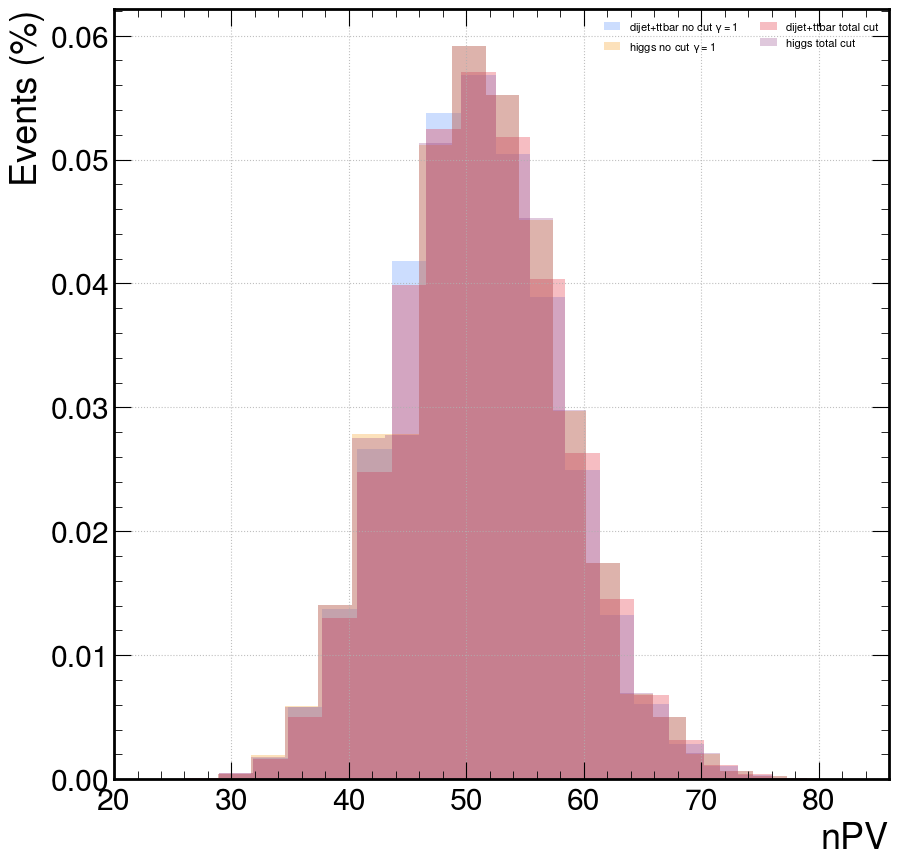

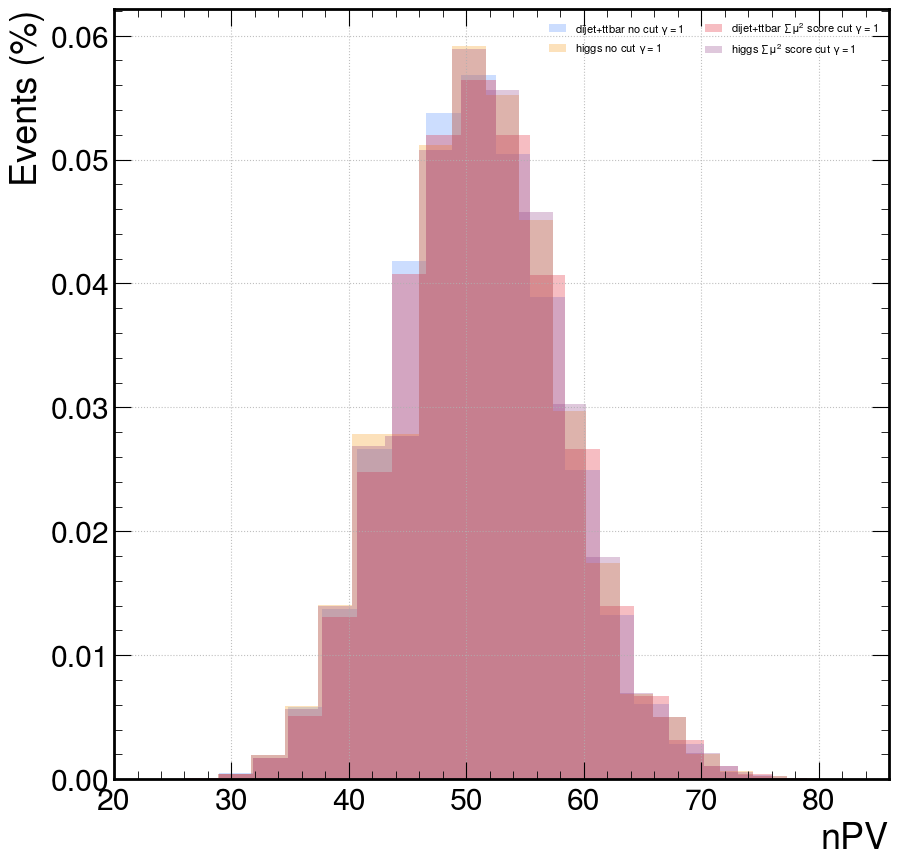

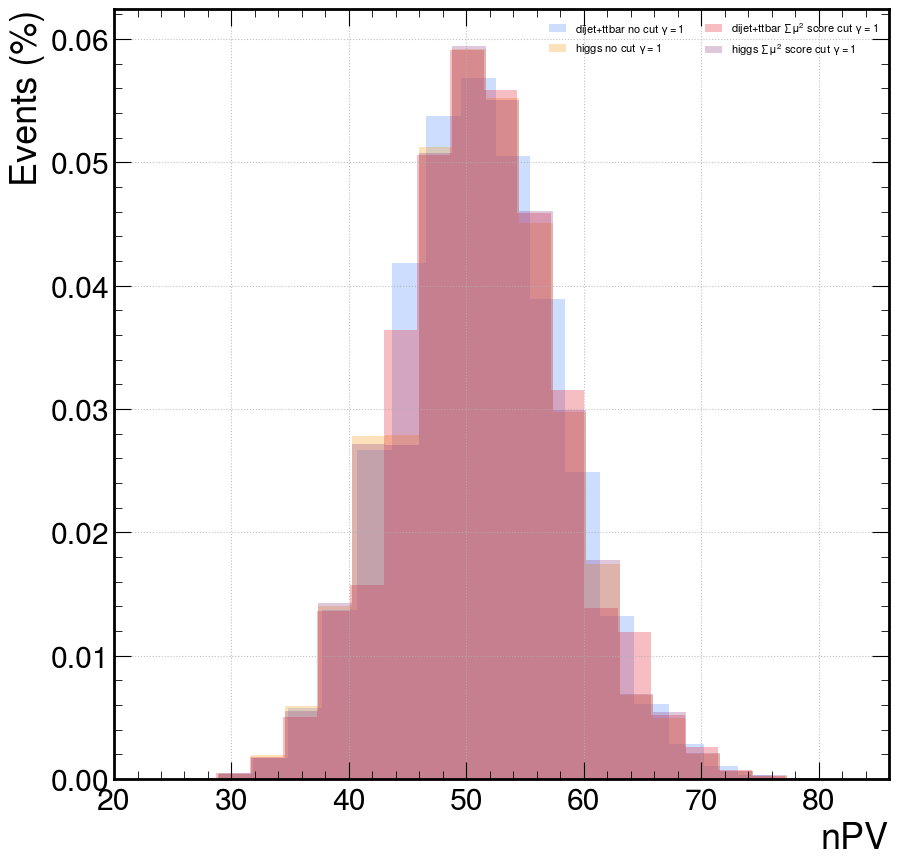

The distributions for dijet+ttbar recon cut are significantly different value=0.046.
No significant difference between the distributions for higgs recon cut with value=0.001.
The distributions for dijet+ttbar KL cut are significantly different value=0.017.
No significant difference between the distributions for higgs KL cut with value=0.005.
The distributions for dijet+ttbar total cut are significantly different value=0.02.
No significant difference between the distributions for higgs total cut with value=0.002.
The distributions for dijet+ttbar $\sum \mu^2$ score cut $\gamma=1$ are significantly different value=0.02.
No significant difference between the distributions for higgs $\sum \mu^2$ score cut $\gamma=1$ with value=0.006.
The distributions for dijet+ttbar $\sum \sigma^2$ score cut $\gamma=1$ are significantly different value=0.018.
No significant difference between the distributions for higgs $\sum \sigma^2$ score cut $\gamma=1$ with value=0.006.


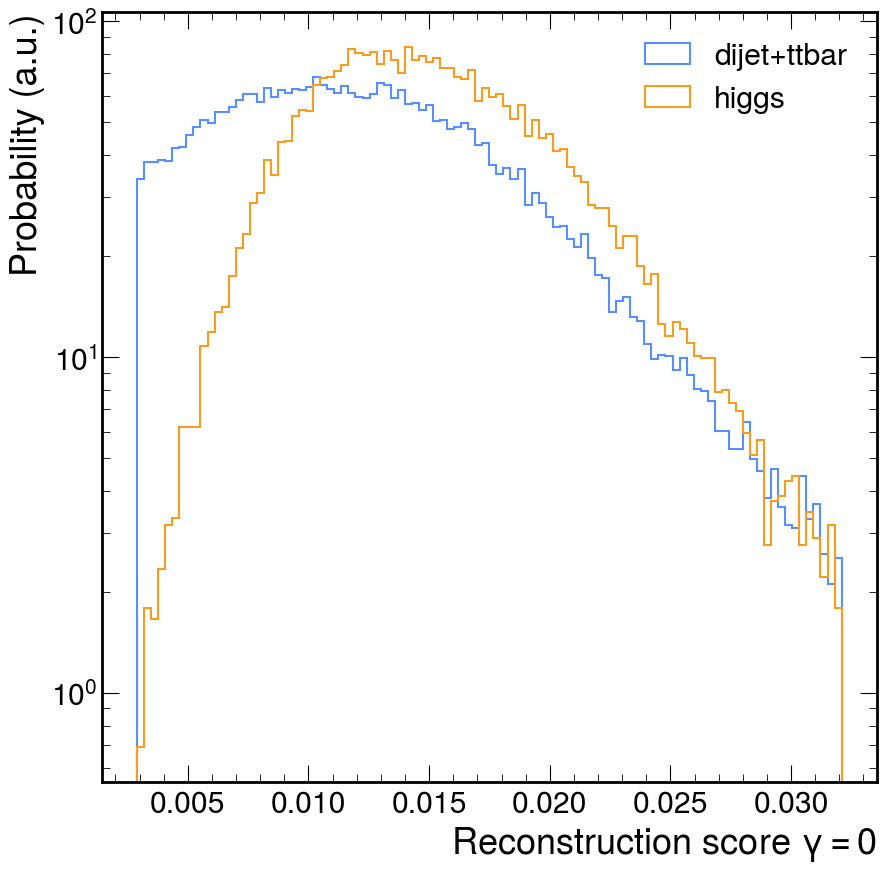

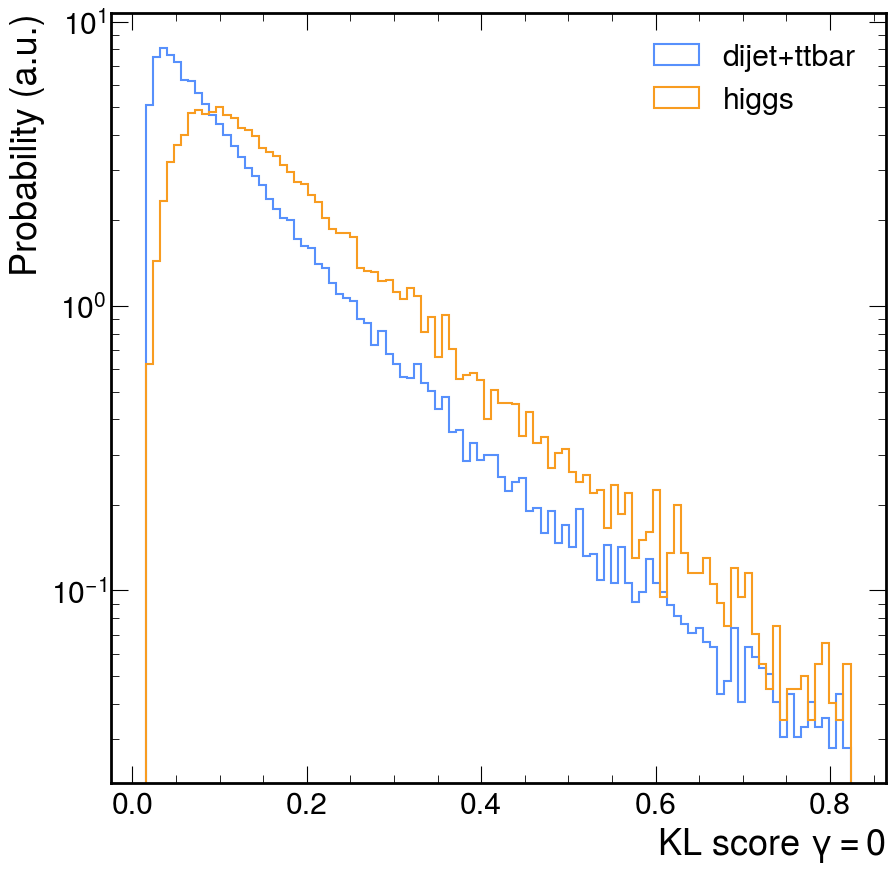

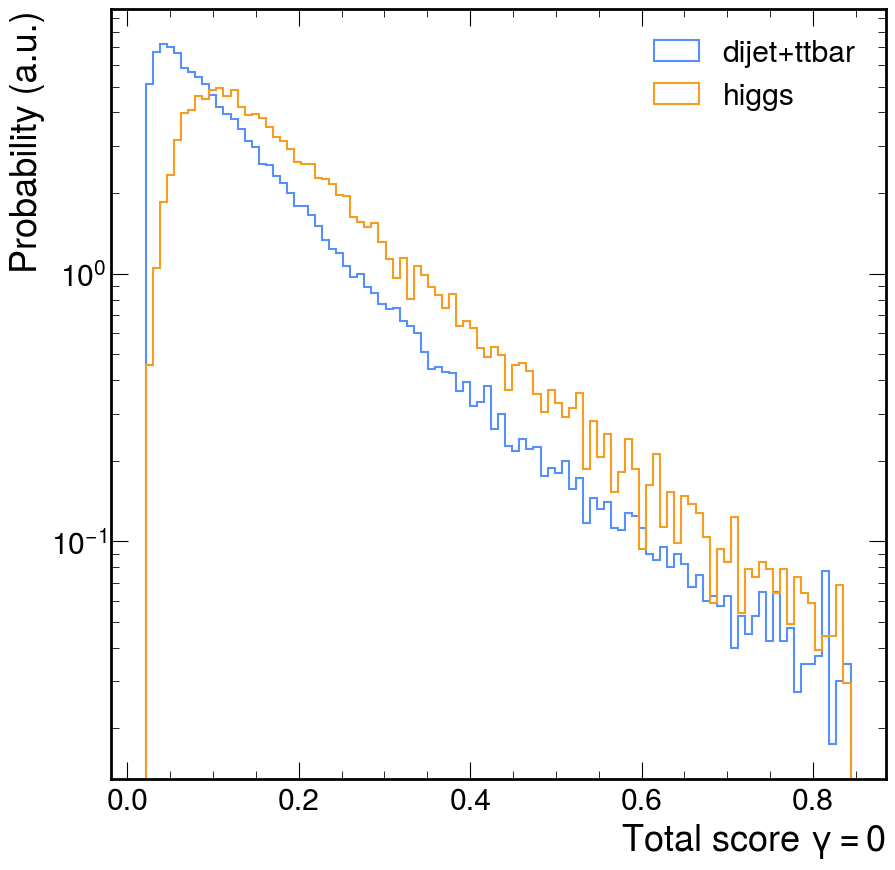

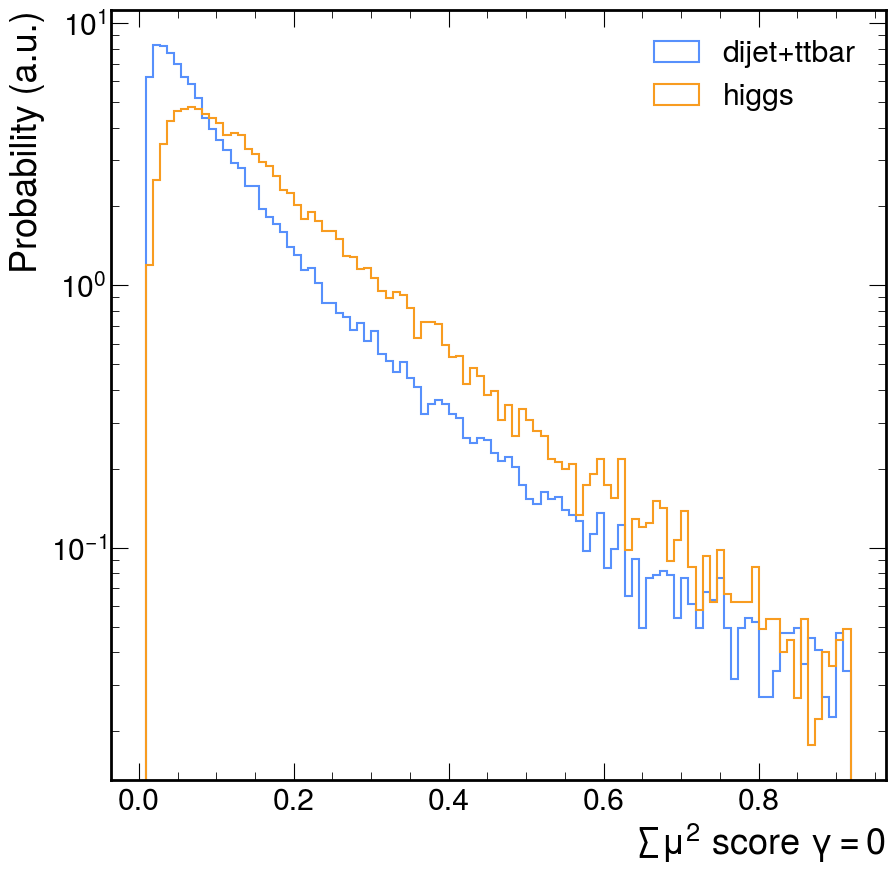

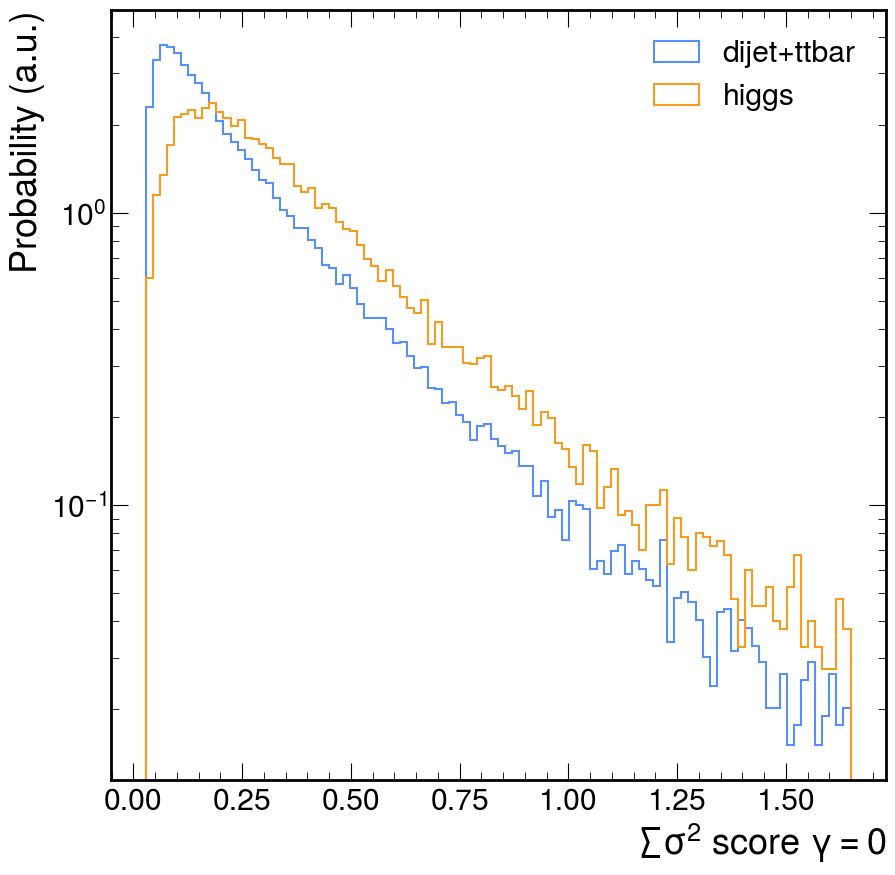

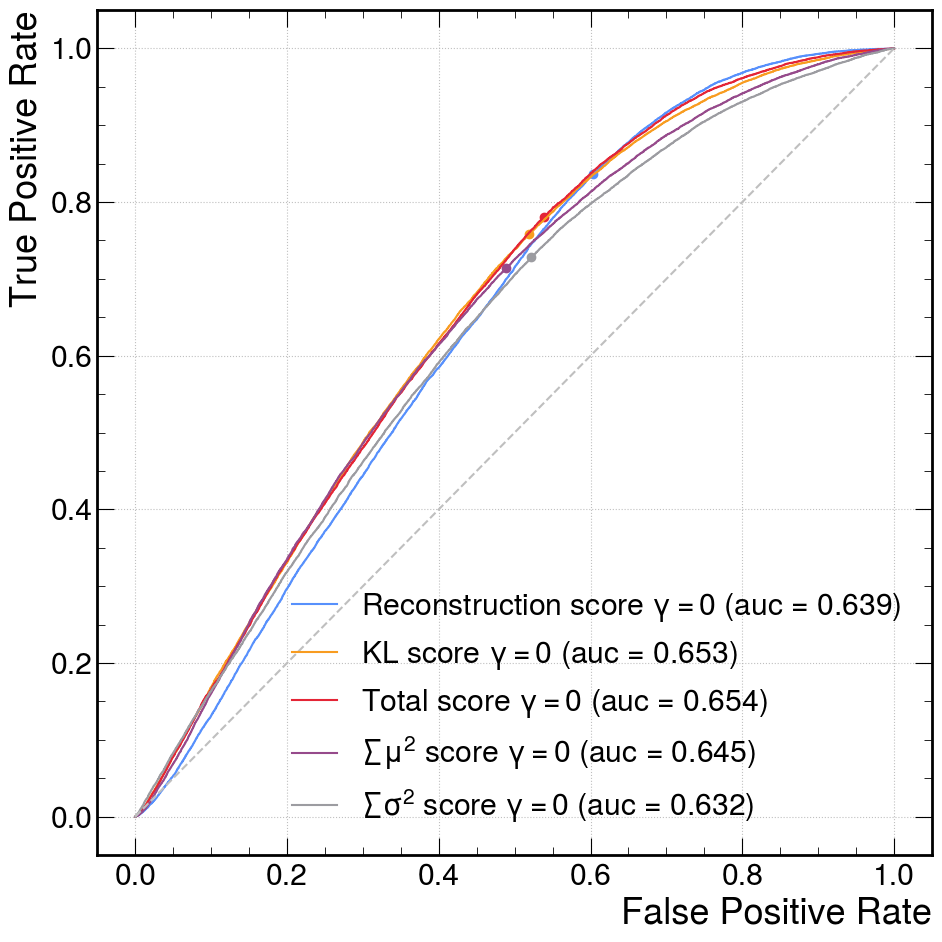

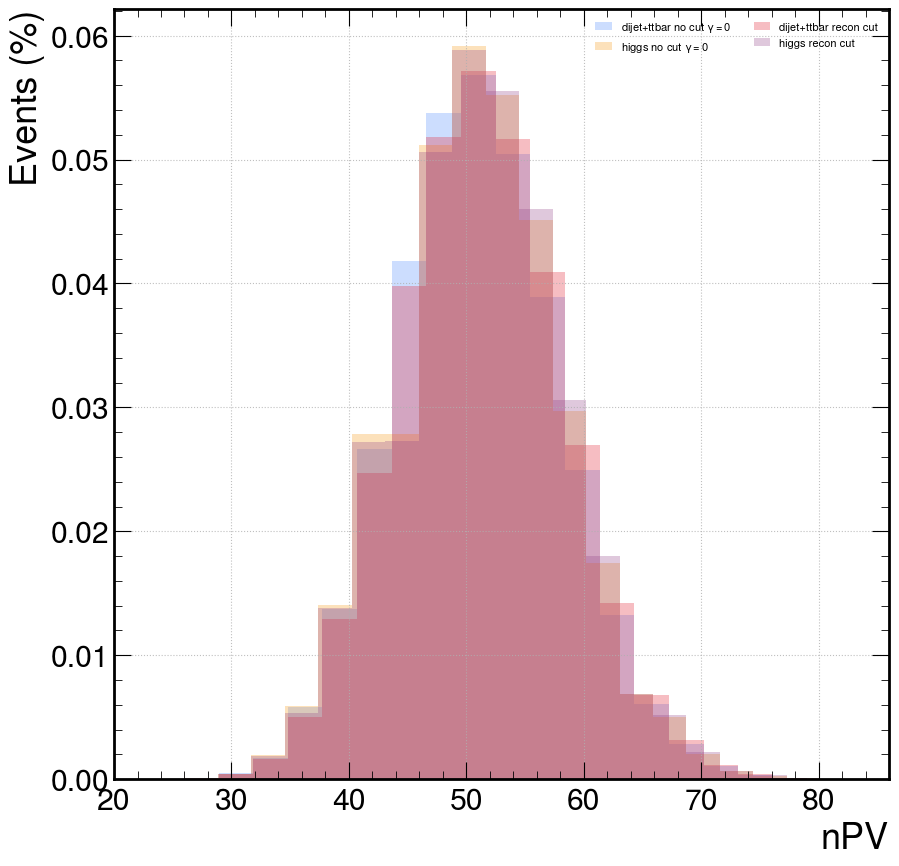

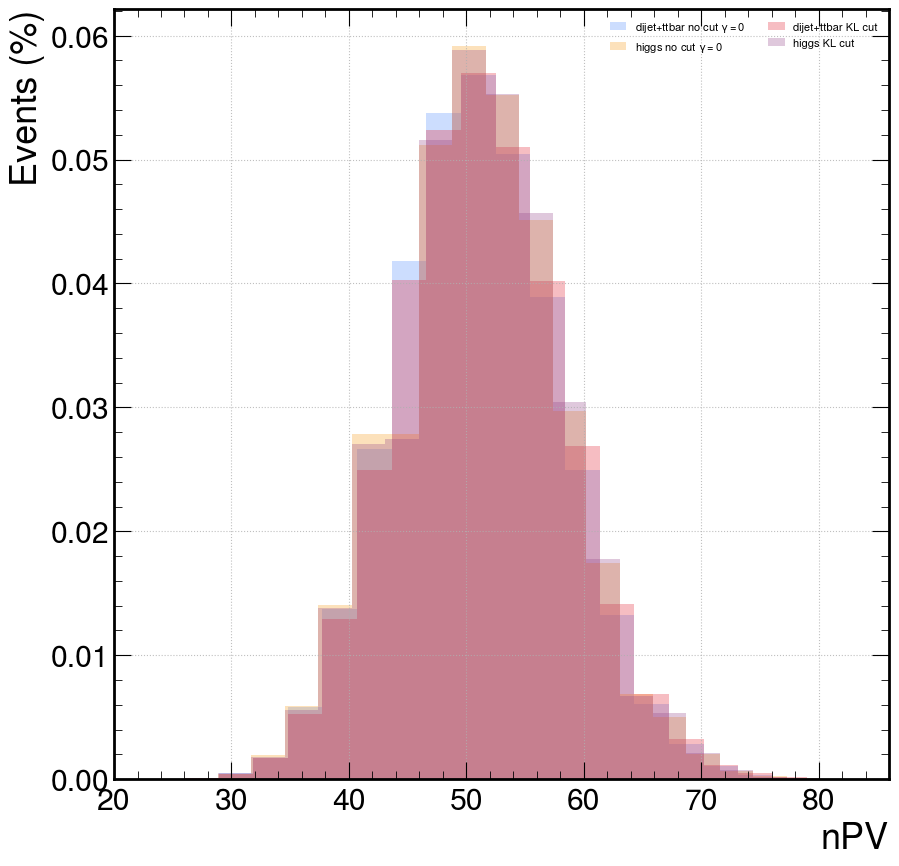

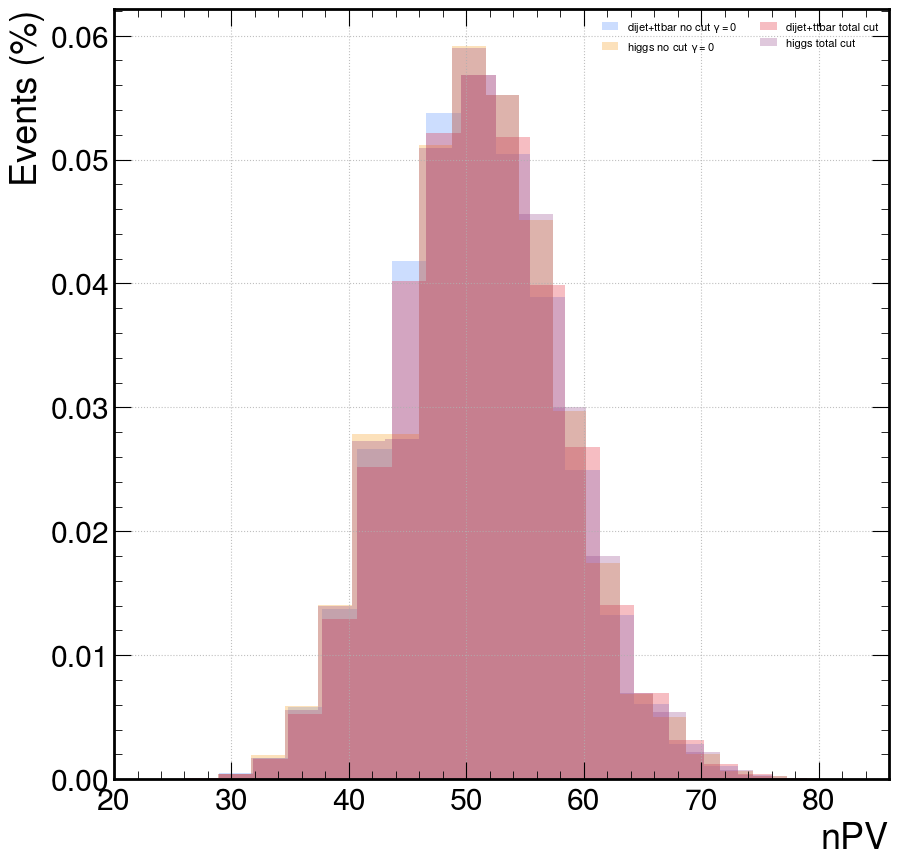

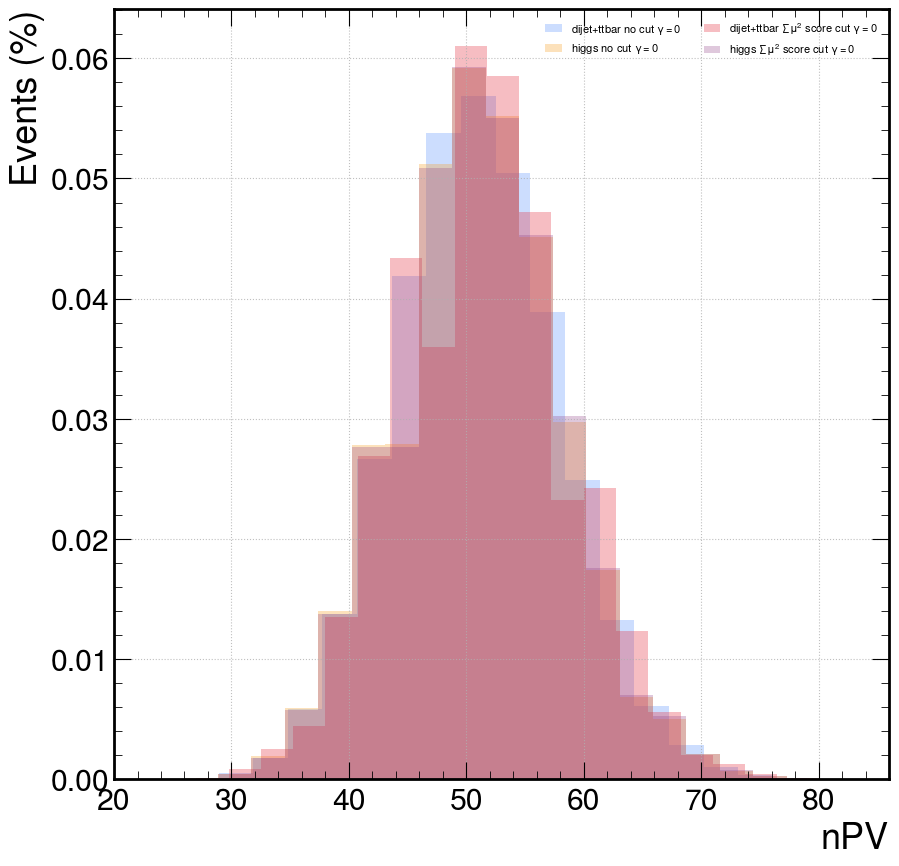

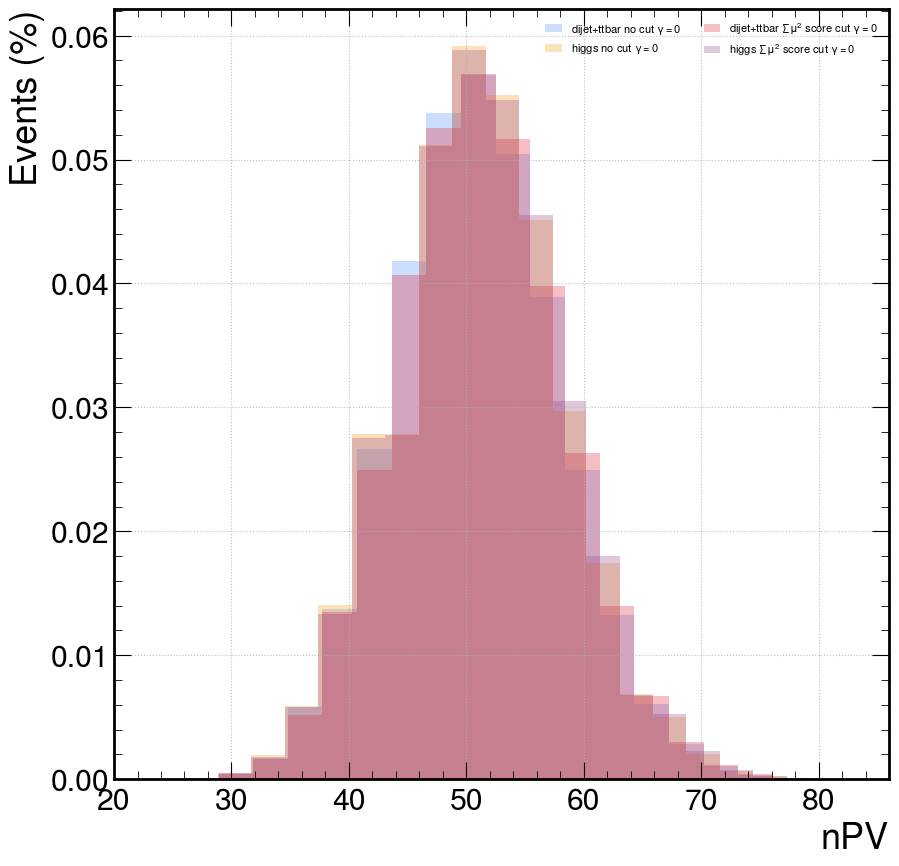

The distributions for dijet+ttbar recon cut are significantly different value=0.023.
No significant difference between the distributions for higgs recon cut with value=0.009.
The distributions for dijet+ttbar KL cut are significantly different value=0.02.
No significant difference between the distributions for higgs KL cut with value=0.006.
The distributions for dijet+ttbar total cut are significantly different value=0.019.
No significant difference between the distributions for higgs total cut with value=0.007.
The distributions for dijet+ttbar $\sum \mu^2$ score cut $\gamma=0$ are significantly different value=0.019.
No significant difference between the distributions for higgs $\sum \mu^2$ score cut $\gamma=0$ with value=0.005.
The distributions for dijet+ttbar $\sum \sigma^2$ score cut $\gamma=0$ are significantly different value=0.015.
No significant difference between the distributions for higgs $\sum \sigma^2$ score cut $\gamma=0$ with value=0.007.


In [9]:
plot_history(history)
get_plots(MiVAE_model, X_test, abnormal_data_test_scaled, nPV_test, nPV_abnormal_test, name=r"$\gamma=1$")
get_plots(MiVAE_model_gamma_zero, X_test, abnormal_data_test_scaled, nPV_test, nPV_abnormal_test, name=r"$\gamma=0$")

### Analyse real data

In [10]:
# setup pre-processing
use_minmax = True
partial_data = 100000

# load model and scaling parameters
axol1tl_model = tf.keras.models.load_model('../data/encoder_trimmed.h5', custom_objects=co)

input_quantizer = quantized_bits(8,5,alpha=1)
scales = h5py.File('../data/scales.h5')
scale_data = scales['norm_scale'][:].flatten()
offset_data = scales['norm_bias'][:].flatten()

In [11]:
# prepare background data for inference
NEG=4
NMU=4
NJET=10

# read in normal data
X = readFromAnomalyBackgroundh5('../data/run370293.h5', object_ranges='default2')

X_flat = np.zeros((X[0]['nEvents'], 57), dtype='int')
X_flat[:,0] = ak.flatten(X[2].sums[:].pt)
X_flat[:,2] = ak.flatten(X[2].sums[:].phi)
X_flat[:,3:3+3*(NEG)] = awkward_to_numpy(X[2].egs, NEG)
X_flat[:,3+3*(NEG):3+3*(NMU+NEG)] = awkward_to_numpy(X[2].muons, NMU)
X_flat[:,3+3*(NMU+NEG):3+3*(NMU+NEG+NJET)] = awkward_to_numpy(X[2].jets, NJET)

# get pile-up
nPV = ak.to_numpy(X[1]['nPV'])
nPV_Good = ak.to_numpy(X[1]['nPV_Good'])

# read in abnormal data
cms_HHHTo6B = readFromAnomalySignalh5('../data/BSM_preprocessed.h5', 'HHHTo6B', object_ranges='default2')

cms_HHHTo6B_flat = np.zeros((cms_HHHTo6B[0]['nEvents'], 57), dtype='int')
cms_HHHTo6B_flat[:,0] = ak.flatten(cms_HHHTo6B[2].sums[:].pt)
cms_HHHTo6B_flat[:,2] = ak.flatten(cms_HHHTo6B[2].sums[:].phi)
cms_HHHTo6B_flat[:,3:3+3*(NEG)] = awkward_to_numpy(cms_HHHTo6B[2].egs, NEG)
cms_HHHTo6B_flat[:,3+3*(NEG):3+3*(NMU+NEG)] = awkward_to_numpy(cms_HHHTo6B[2].muons, NMU)
cms_HHHTo6B_flat[:,3+3*(NMU+NEG):3+3*(NMU+NEG+NJET)] = awkward_to_numpy(cms_HHHTo6B[2].jets, NJET)


In [10]:
# split data for training / testing
X_train, X_test, nPV_train, nPV_test = train_test_split(X_flat.astype('float')[:partial_data], nPV_Good[:partial_data], random_state=42)

In [13]:
# scale data
scaler = MinMaxScaler()
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)
cms_HHHTo6B_minmax = scaler.transform(cms_HHHTo6B_flat.astype('float'))

X_train_axiol1tl = input_quantizer((X_train - offset_data) / scale_data)
X_test_axiol1tl = input_quantizer((X_test - offset_data) / scale_data)
cms_HHHTo6B_axiol1tl = input_quantizer((cms_HHHTo6B_flat.astype('float') - offset_data) / scale_data)

In [14]:
# train the model
MiVAE_cms_model = MiVAE(
    verbose=2,
    use_qkeras=False,
    use_quantflow=True,
    use_batchnorm=True,
    use_quantized_sigmoid=False,
    batch_size=256,
    beta_param=1,
    drop_out=0.0,
    alpha=1,
    init_quantized_bits=16,
    epoch=20,
    gamma=1,
    num_samples=1,
    hidden_layers=[32, 16],
    latent_dims=8,
    learning_rate=0.0001,
    optimizer="Adam",
    patience=100,
    mi_loss=True,
    run_eagerly=False
)
history = MiVAE_cms_model.fit(X_train_minmax, nPV_train)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 57)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_activation_8     │ (None, 57)        │          1 │ input_layer_18[0… │
│ (TQActivation)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_16         │ (None, 32)        │      1,859 │ tq_activation_8[… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ tq_dense_16[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tq_dense_17         │ (None, 16)        │        531 │ batch_normalizat… │
│ (TQDense)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ tq_dense_17[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (TQDense)    │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (TQDense) │ (None, 8)         │        139 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_9          │ (None, 8)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bernoulli           │ (None, 8)         │          0 │ sampling_9[0][0]  │
│ (BernoulliSampling) │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,861 (11.18 KB)

 Trainable params: 2,765 (10.80 KB)

 Non-trainable params: 96 (384.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 57)             │         1,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,761 (10.79 KB)

 Trainable params: 2,665 (10.41 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/20


W0000 00:00:1736791479.682431 94878566 loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/map/while/body/_141/map/while/cond/branch_executed/_777


586/586 - 6s - 10ms/step - bops: 42510.0156 - kl_loss: 11.7052 - loss: 42522.5273 - mi_loss: 0.7365 - reconstruction_loss: 0.0755
Epoch 2/20
586/586 - 3s - 5ms/step - bops: 42409.2734 - kl_loss: 7.0495 - loss: 42417.0391 - mi_loss: 0.6946 - reconstruction_loss: 0.0267
Epoch 3/20
586/586 - 3s - 5ms/step - bops: 42336.5352 - kl_loss: 5.2489 - loss: 42342.4648 - mi_loss: 0.6555 - reconstruction_loss: 0.0157
Epoch 4/20
586/586 - 3s - 5ms/step - bops: 42279.5547 - kl_loss: 4.2254 - loss: 42284.4102 - mi_loss: 0.6233 - reconstruction_loss: 0.0135
Epoch 5/20
586/586 - 3s - 5ms/step - bops: 42232.6641 - kl_loss: 3.5222 - loss: 42236.7852 - mi_loss: 0.5971 - reconstruction_loss: 0.0128
Epoch 6/20
586/586 - 3s - 5ms/step - bops: 42192.8320 - kl_loss: 3.0075 - loss: 42196.4102 - mi_loss: 0.5721 - reconstruction_loss: 0.0125
Epoch 7/20
586/586 - 3s - 5ms/step - bops: 42158.1992 - kl_loss: 2.6064 - loss: 42161.3633 - mi_loss: 0.5485 - reconstruction_loss: 0.0123
Epoch 8/20
586/586 - 3s - 5ms/step -

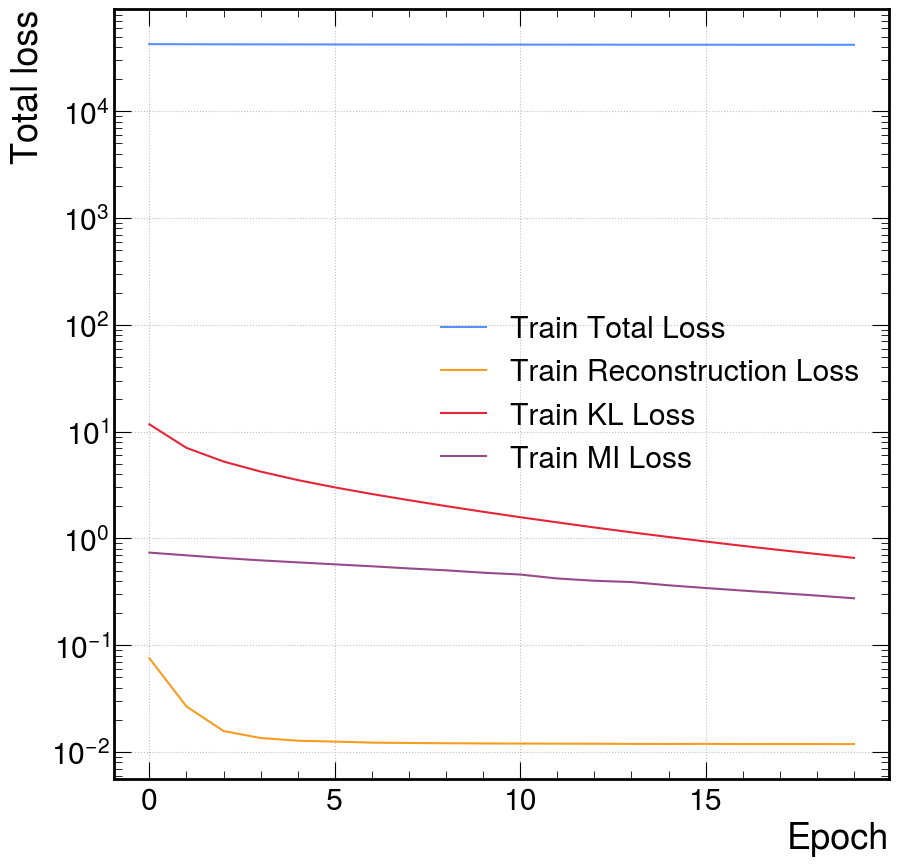

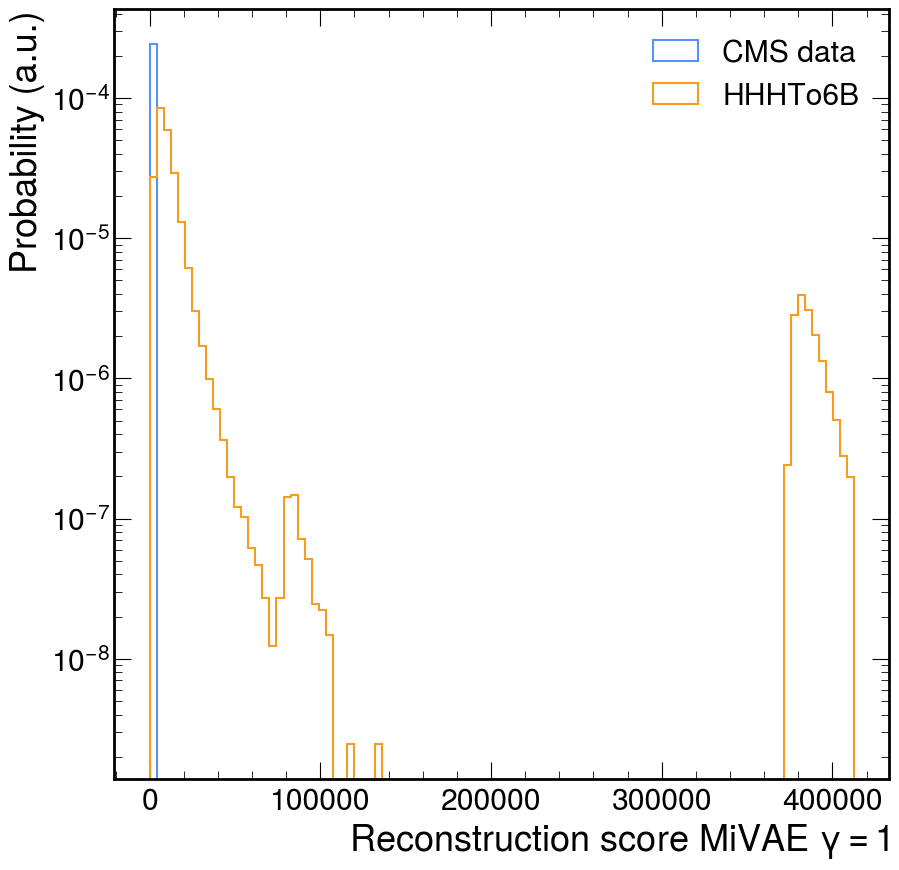

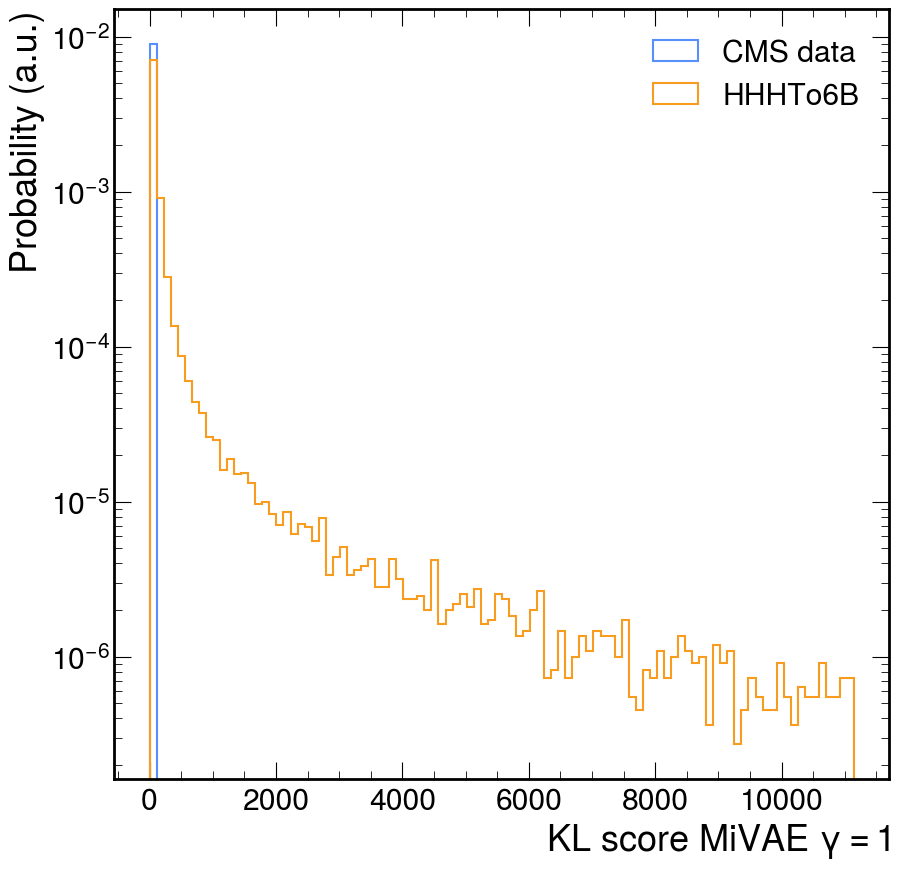

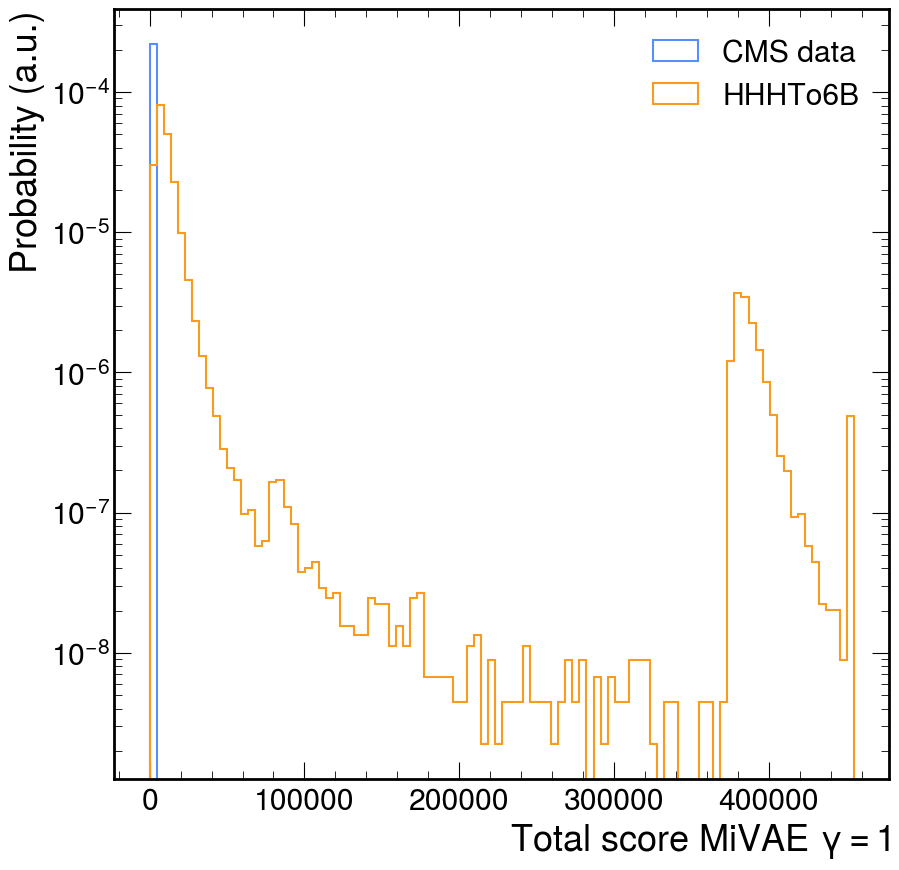

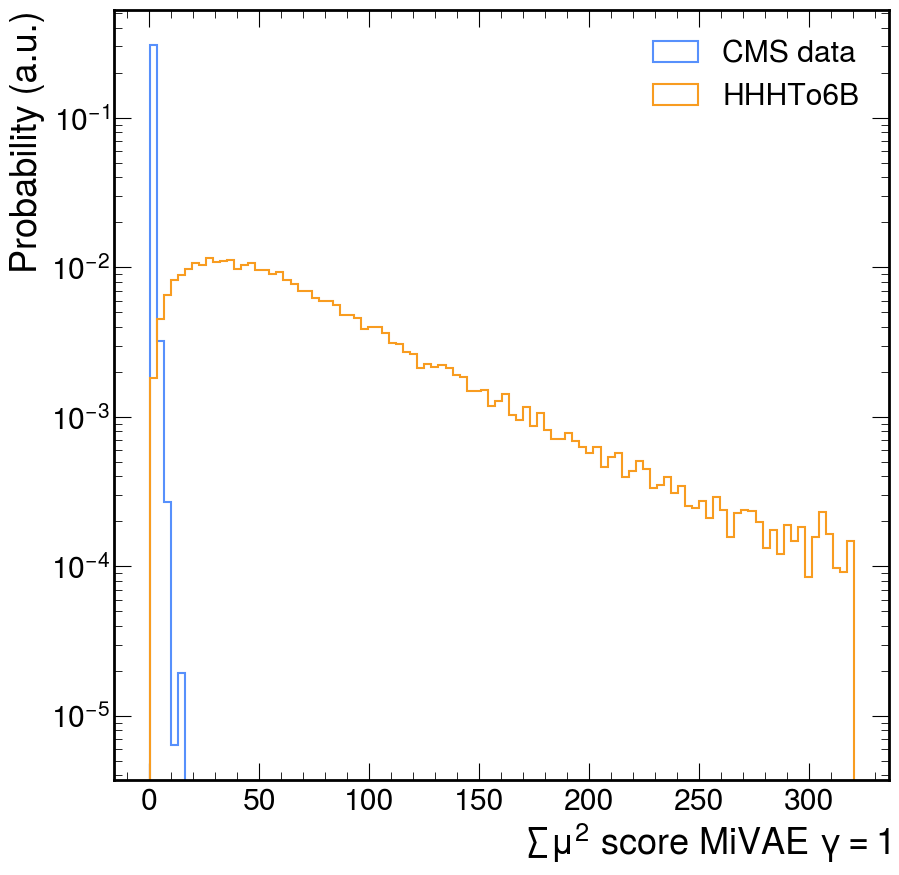

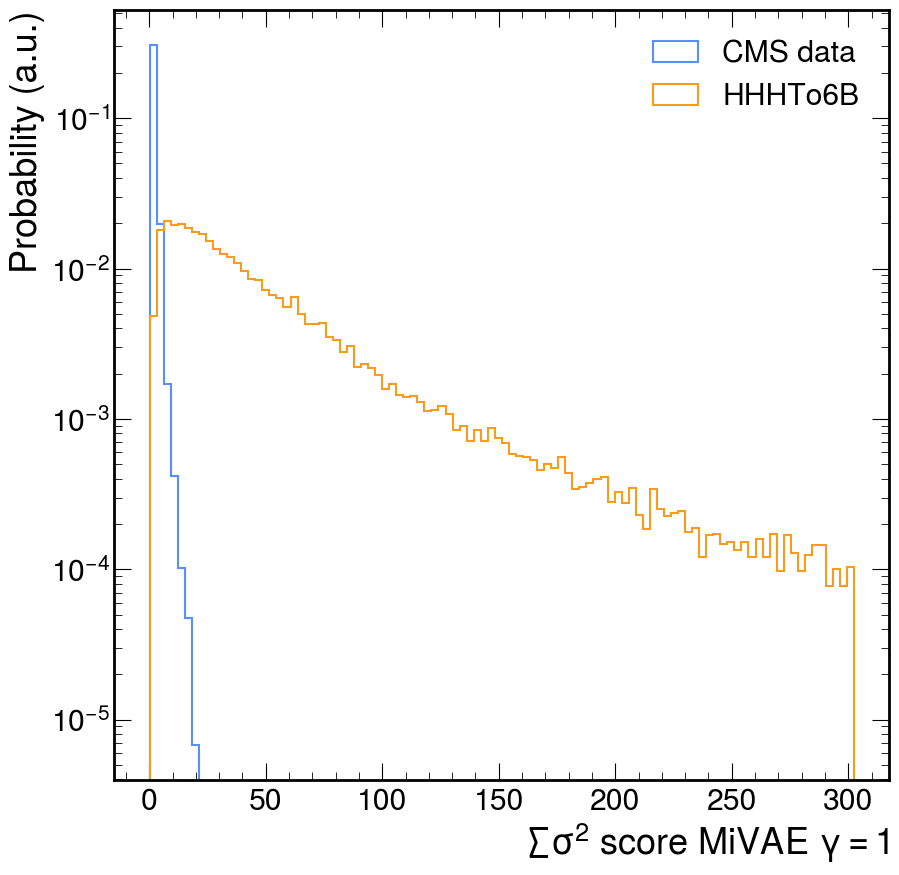

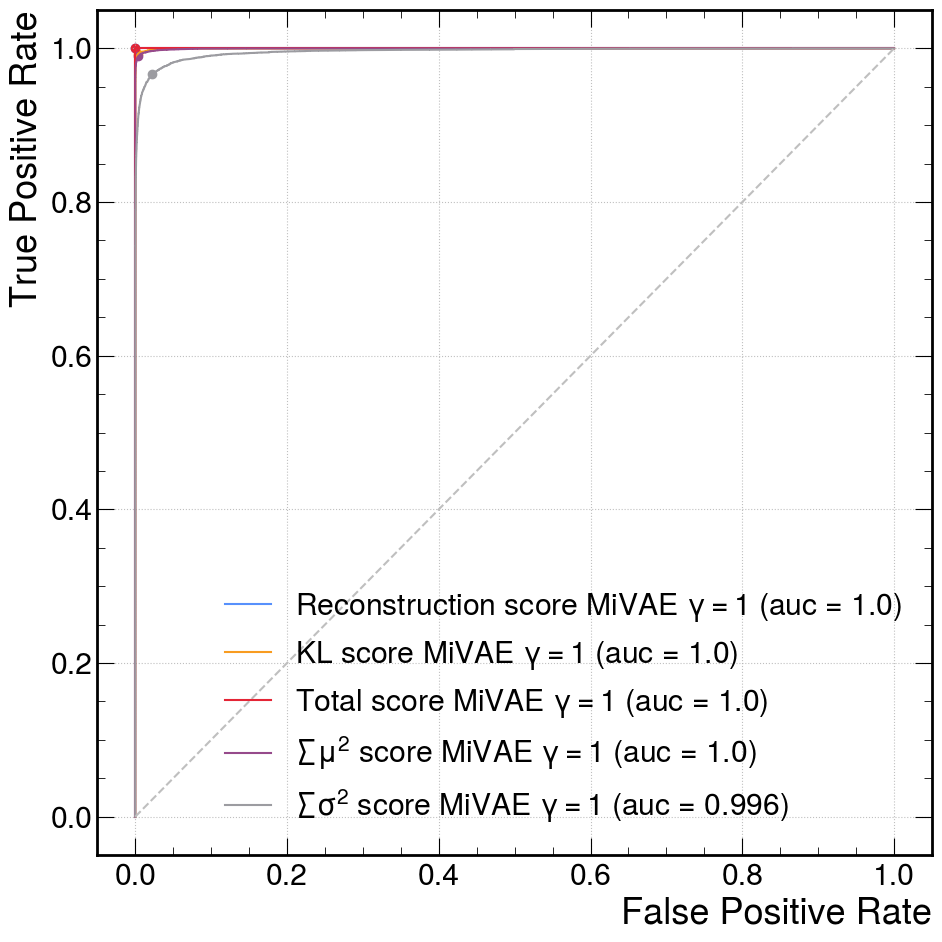

/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


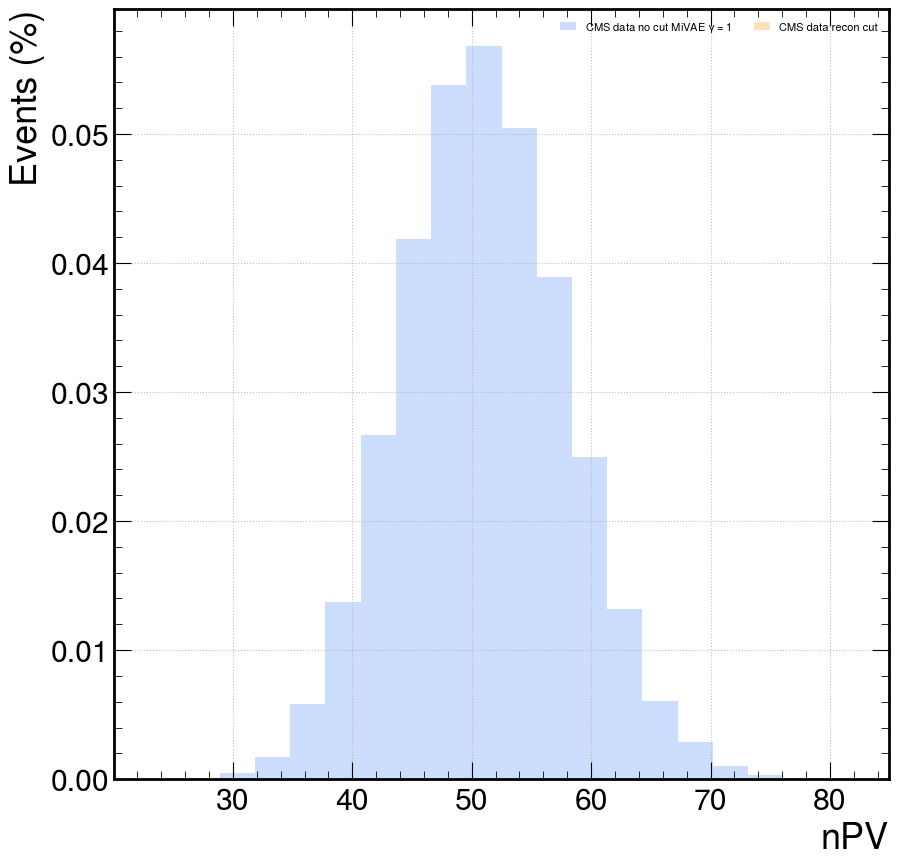

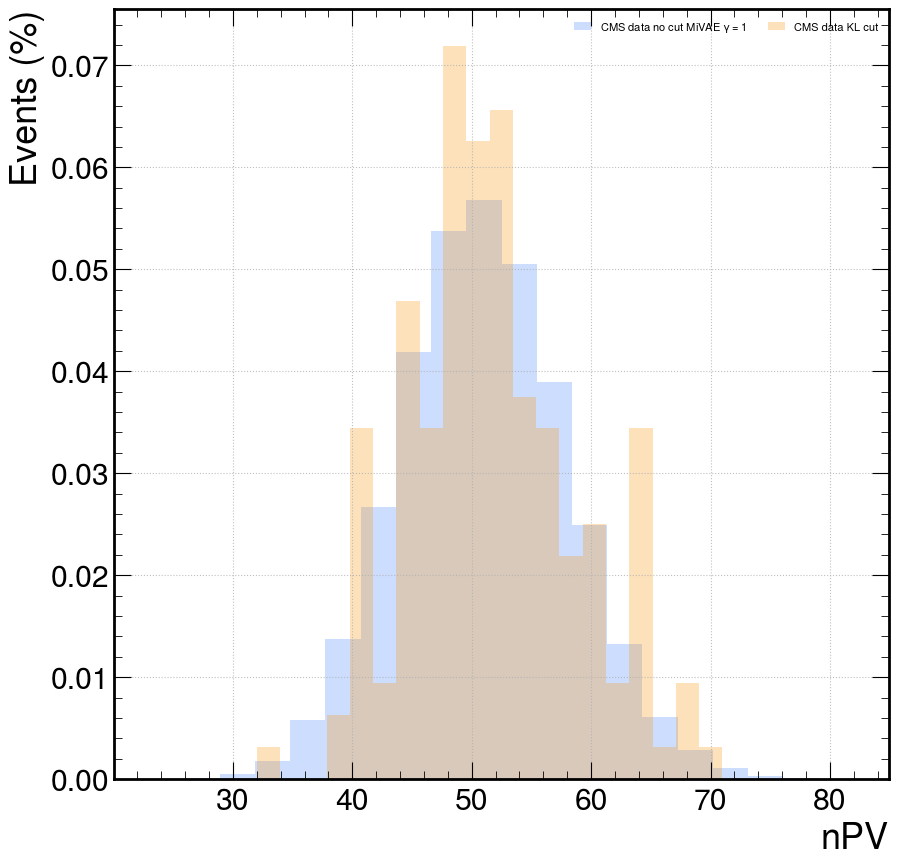

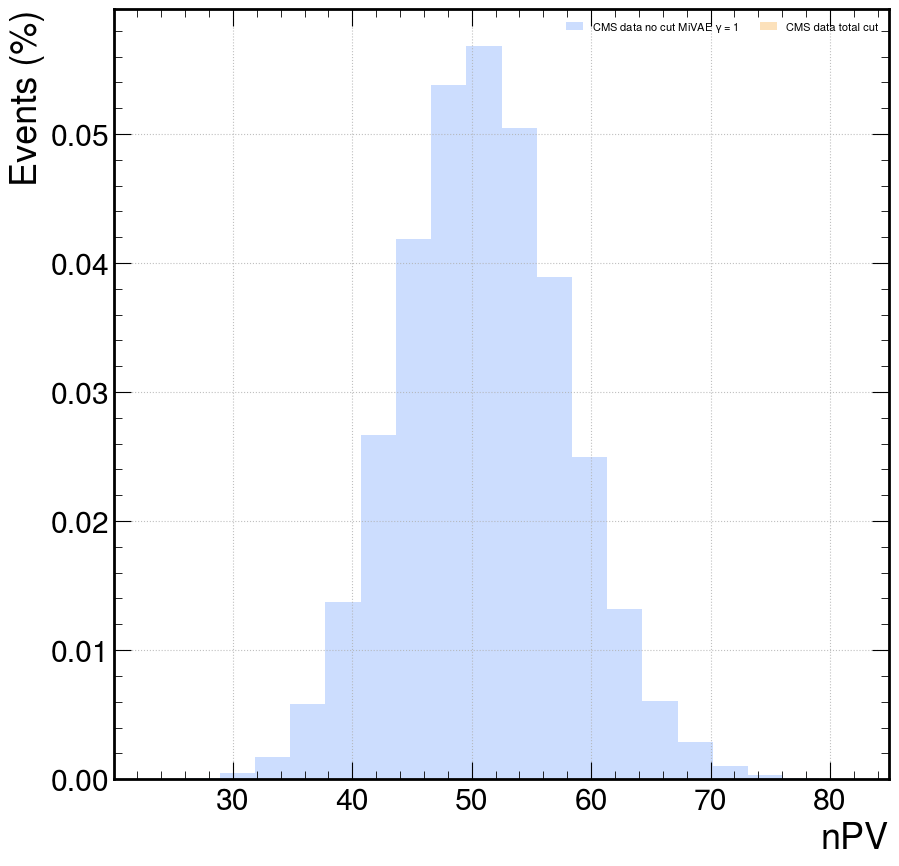

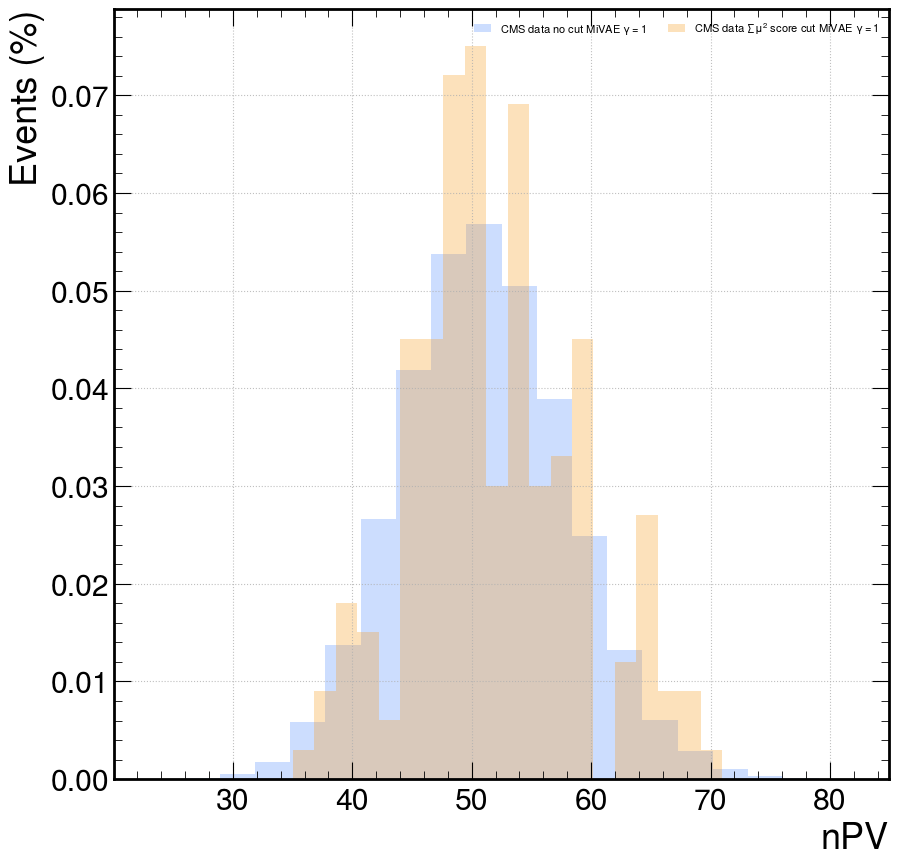

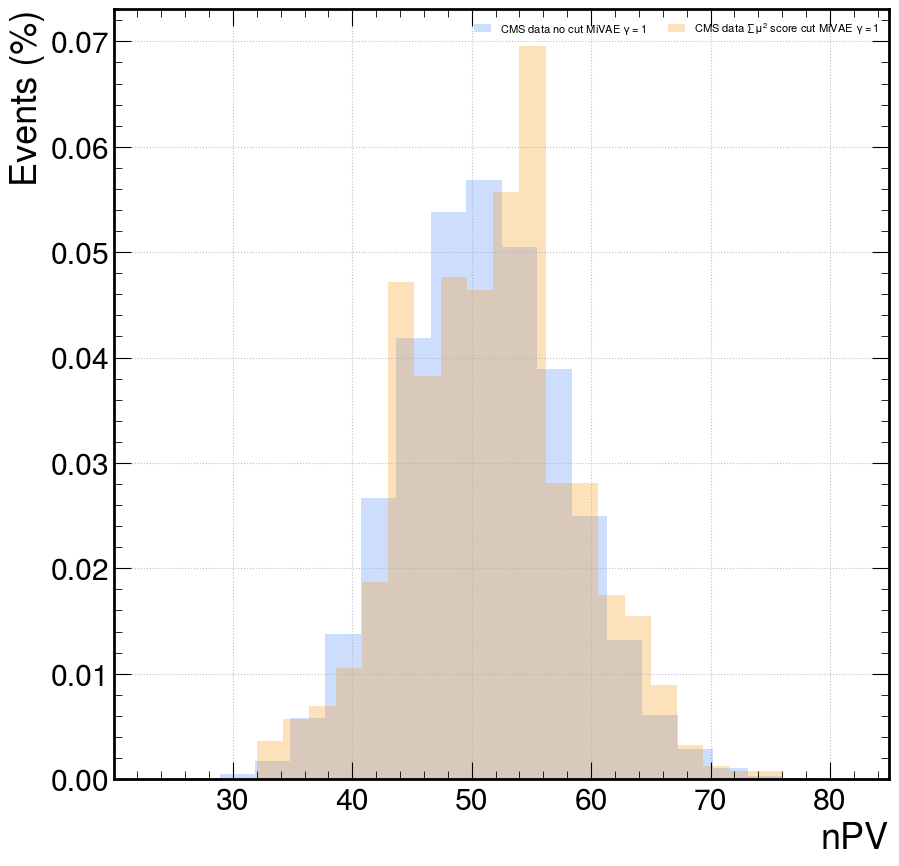

No significant difference between the distributions for CMS data KL cut with value=0.058.
No significant difference between the distributions for CMS data $\sum \mu^2$ score cut MiVAE $\gamma=1$ with value=0.063.
The distributions for CMS data $\sum \sigma^2$ score cut MiVAE $\gamma=1$ are significantly different value=0.043.


In [15]:
plot_history(history)
get_plots(MiVAE_cms_model, X_test_minmax, cms_HHHTo6B_minmax[:partial_data], nPV_test, None, name=r"MiVAE $\gamma=1$", label_normal="CMS data", label_abnormal="HHHTo6B")

 582/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step

W0000 00:00:1736791561.202826 94878566 loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: model_1_1/mu_1/cond_1/branch_executed/_63


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 402us/step


W0000 00:00:1736791561.822864 94878566 loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: model_1_1/mu_1/cond_1/branch_executed/_63


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1s 247us/step


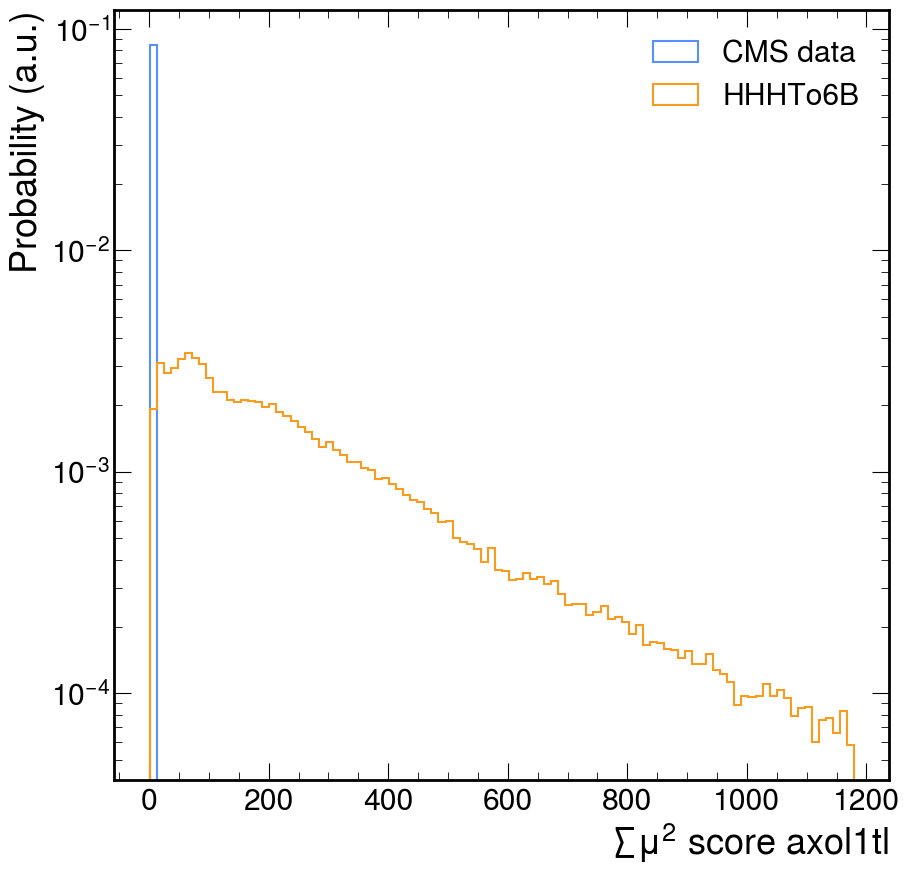

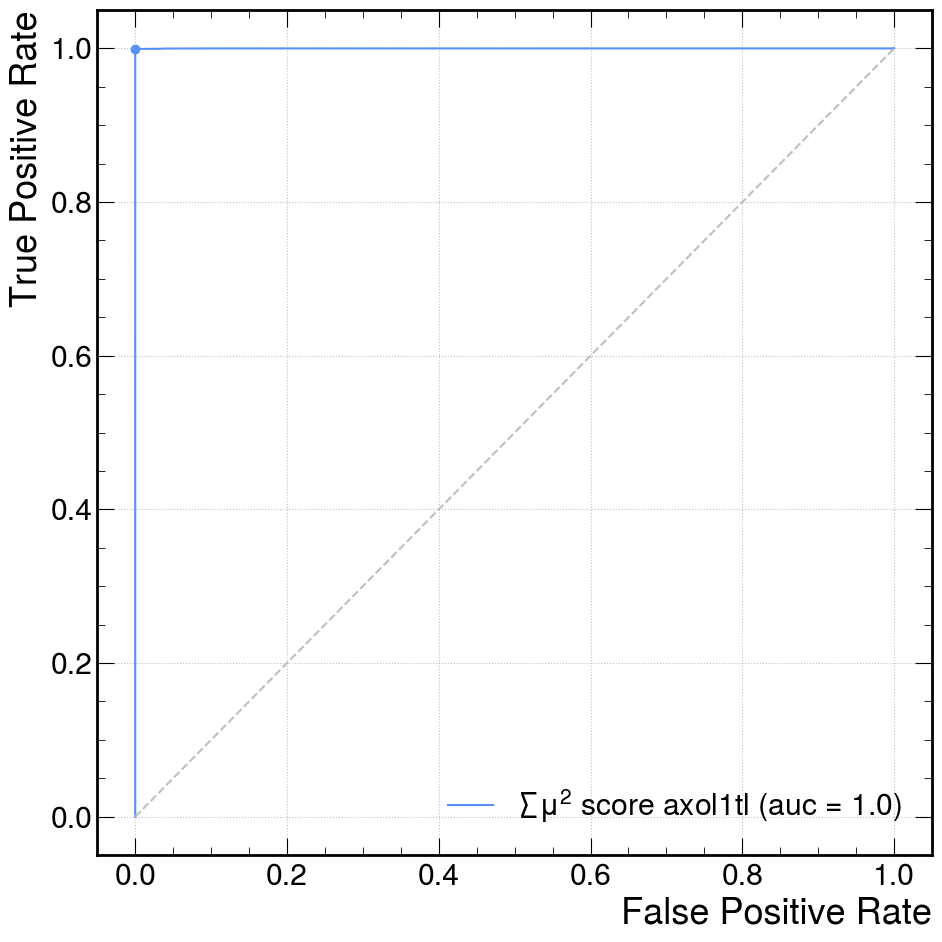

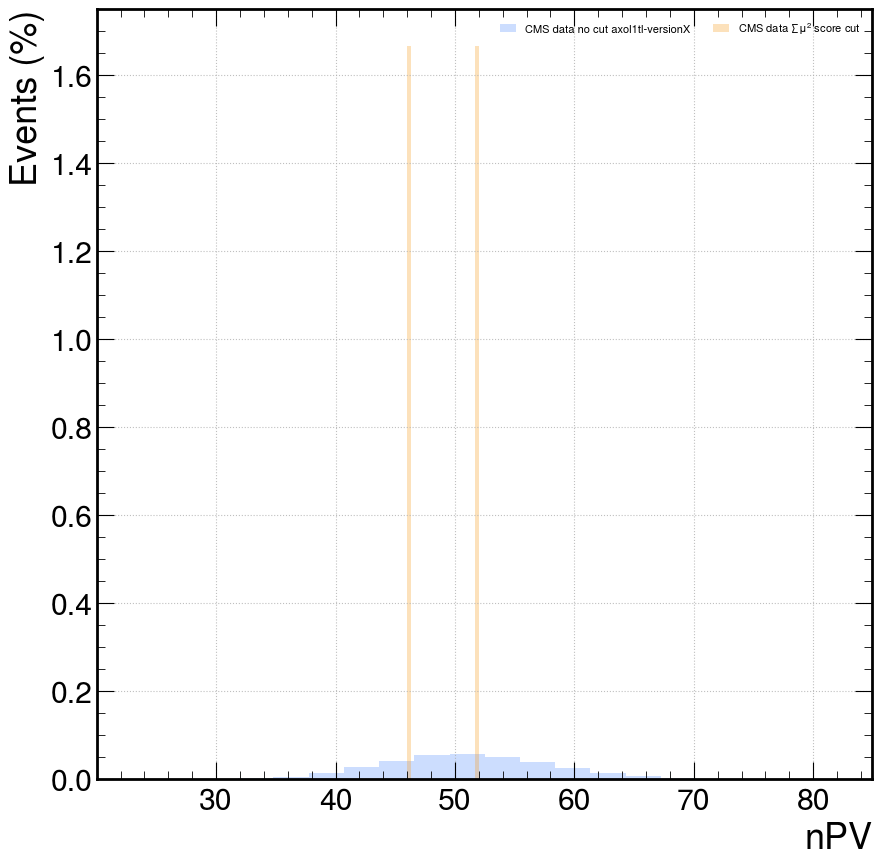

No significant difference between the distributions for CMS data $\sum \mu^2$ score with value=0.407.


In [16]:
get_plots(axol1tl_model, X_test_axiol1tl, cms_HHHTo6B_axiol1tl[:partial_data], nPV_test, None, name="axol1tl-versionX", label_normal="CMS data", label_abnormal="HHHTo6B", use_axio=True)

In [35]:
axol1tl_model.summary()

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_3 (InputLayer)            │ (None, 57)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ q_dense (QDense)                │ (None, 32)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ q_dense_1 (QDense)              │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mu (QDense)                     │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,520 (9.84 KB)

 Trainable params: 2,520 (9.84 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def custom_scorer(estimator, X, y, abnormal_data_train_scaled):
    kl_loss = estimator.score_vector(X)[1]
    mean_loss = estimator.get_mean(X).numpy()
    sigma_loss = estimator.get_sigma(X).numpy()

    kl_loss_abnorm = estimator.score_vector(abnormal_data_train_scaled)[1]
    mean_loss_abnorm = estimator.get_mean(abnormal_data_train_scaled).numpy()
    sigma_loss_abnorm = estimator.get_sigma(abnormal_data_train_scaled).numpy()

    X = np.column_stack((kl_loss, mean_loss, sigma_loss))
    X_abnorm = np.column_stack((kl_loss_abnorm, mean_loss_abnorm, sigma_loss_abnorm))
    X_total = np.concatenate((X_abnorm, X))
    X_total = np.nan_to_num(X_total)
    y = np.concatenate((np.ones(len(abnormal_data_train_scaled)), np.zeros(len(X))))

    X_train, X_test, y_train, y_test = train_test_split(X_total, y, shuffle=True, stratify=y)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    reg = linear_model.LogisticRegression()
    reg.fit(X_train, y_train)
    auc = roc_auc_score(y_test, reg.predict_proba(X_test)[:,1])

    return auc

scorer = partial(custom_scorer, abnormal_data_train_scaled=abnormal_data_train_scaled)

param_grid = {
    'hidden_layers': [[32, 16], [64, 32]],  # Different network architectures
    'activation': ['relu', 'tanh', 'sigmoid'],  # Different activation functions
    'latent_dims': [4, 8, 16],  # Latent space dimensions
    'drop_out': [0.0, 0.2, 0.4],  # Dropout rates
    'beta_param': [1, 10, 100],  # Weight for KL loss
    'gamma': [1, 10, 100],
    'batch_size': [32, 64, 128, 256],  # Batch sizes
    'learning_rate': [0.001, 0.0001],  # Learning rates
    'optimizer': ['Adam'],  # Different optimizers
    'epoch': [10, 50, 100],  # Number of epochs
    'quantize': [True],
    'num_samples': [10]
}

MiVAE_model = MiVAE(verbose=0, run_eagerly=False, epoch=100, batch_size=256, latent_dims=8, drop_out=0)

grid_search = RandomizedSearchCV(
    MiVAE_model,
    param_grid,
    cv=3,
    n_jobs=1,
    n_iter=10,
    verbose=3,
    scoring=scorer,
    refit=True
)
grid_search.fit(X_train, nPV_train)